#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [2]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 6
FILTER_NUM = 24

TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All128'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 128

# BATCH_SIZE = 120
BATCH_SIZE = 5
EPOCHS = 1500

BASE_DIR = '/workspace/BoneMeta_all_128'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'

In [3]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [4]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_128/images 317
/workspace/BoneMeta_all_128/labels 317


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = ['KH027_20210801_Chest(+).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000311_20190902_Chest_CT_(contrast).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000506_20201113_Chest_CT_(contrast).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH042_20210501_Chest(+).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', '000364_20191217_Chest_CT_(contrast).npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'KH023_20210901_Chest(+).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', '000224_20190228_Chest_CT_(contrast).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH016_20191101_Chest(+).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', '000356_20191024_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy', '000530_20210428_Chest_CT_(contrast).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH001_20210501_Chest(+).npy', 'KH031_20210801_Chest(+).npy', 'KH010_20201201_Chest(+).npy', '000370_20200117_Chest_CT_(contrast).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', '000080_20180911_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', '000085_20180829_Chest_CT_(contrast).npy', '000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', '000386_20200204_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000325_20190919_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_Chest(+).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', '000279_20190614_Chest_3DCT_(contrast).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', 'KH026_20210801_Chest(+).npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', '000322_20190913_Chest_CT_(contrast).npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy', 'KH037_20210401_Chest(+).npy', '000309_20190823_Chest_CT_(contrast).npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000424_20200218_Chest_CT_(contrast).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', '000262_20190529_Chest_CT_(contrast).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000481_20200722_Chest_CT_(noncontrast).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000409_20200310_Chest_CT_(contrast).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', '000560_20210706_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', '000506_20201110_CT_Urography_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH033_20210701_Chest(+).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000475_20210210_Chest_CT_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', '000278_20190620_Chest_CT_(contrast).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'KH032_20210701_Chest(+).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', '000242_20190409_Chest_CT_(contrast).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH036_20210401_Chest(+).npy', '000330_20190926_Chest_CT_(contrast).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', '000362_20191214_Chest_CT_(contrast).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH040_20210301_Chest(+).npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', '000069_20180319_Chest_CT_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000494_20210405_Chest_CT_(contrast).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH025_20211001_Chest(+).npy', '000021_20181227_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', '000011_20181207_Chest_CT_(contrast).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH024_20211001_Chest(+).npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH009_20200801_Chest(+).npy', '000376_20200114_Chest_CT_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH007_20200601_Chest(+).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', '000557_20210621_Chest_CT_(contrast).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', '000304_20190124_CT_Liver_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', '000541_20210520_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000481_20210409_CT_Liver_(contrast).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', '000533_20210507_CT_Liver_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', '000308_20190826_Chest_CT_(contrast).npy', 'KH038_20210401_Chest(+).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000344_20191125_Chest_CT_(contrast).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['BH099_20200806_Abdomen_&_pelvis_CT.npy', '000019_20181018_Chest_CT_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000251_20190429_Chest_CT_(contrast).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH027_20191001_L-spine_CT_(3D).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000285_20190807_Chest_CT_(contrast).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', '000193_20190114_Chest_CT_(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000316_20190627_Chest_CT_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy', '000450_20200512_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']
TEST_FILES = ['000214_20190325_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000236_20190401_CT_Abdomen+Pelvis_Post_(contrast).npy', '000244_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000314_20190827_Chest_CT_(contrast).npy', '000314_20190901_CT_Acute_Abdomen_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000383_20200121_Chest_CT_(contrast).npy', 'BH001_20190401_Chest_CT_(Non_contrast)_+_3D.npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH047_20180901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 238
val: 35
test: 30
total: 303



In [12]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [13]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
# len(train_dataset)

In [16]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [17]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [18]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 1.1069047569999384s
train: 238
val: 35



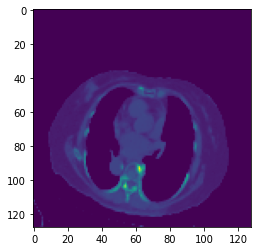

In [19]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

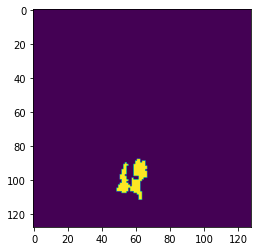

In [20]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [21]:
import multiprocessing
multiprocessing.cpu_count()

48

In [22]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [23]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [24]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [25]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [26]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=1, num_groups=FILTER_NUM, f_maps=FILTER_NUM, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0005, weight_decay=0.0001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [27]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

79594303

In [29]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

def diceLoss(prediction_g, label_g, epsilon=0.00001):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [30]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [31]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [32]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [33]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 40
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-09-04 16:43:32,363 INFO     pid:1544 3DUnet:001:<cell line: 1> Starting traning...


In [34]:
for epoch_ndx in range(1, 1001):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-09-04 16:43:32,374 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1 of 1500, 12/7 batches of size 5*4
2022-09-04 16:43:32,378 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1 Training ----/12, starting
2022-09-04 16:44:30,118 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1 Training ----/12, done at 2022-09-04 16:44:30
2022-09-04 16:44:30,125 INFO     pid:1544 3DUnet:004:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 16:44:30,128 INFO     pid:1544 3DUnet:035:logMetrics E1 trn      0.9949 loss, 0.0050 precision, 0.1140 recall, 0.0096 f1 score
2022-09-04 16:44:30,129 INFO     pid:1544 3DUnet:045:logMetrics E1 trn_all  0.9949 loss,  11.4% tp,  88.6% fn,    2261.0% fp
2022-09-04 16:44:30,142 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1 Validation  ----/7, starting
2022-09-04 16:44:34,223 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1 Validation  ----/7, done at 2022-09-04 16:44:34
2022-09-04 16:44:34,438 INFO     pid:154

2022-09-04 16:51:10,860 WARNING  pid:1544 util.util:219:enumerateWithEstimate E11 Training ----/12, starting
2022-09-04 16:51:53,690 WARNING  pid:1544 util.util:249:enumerateWithEstimate E11 Training ----/12, done at 2022-09-04 16:51:53
2022-09-04 16:51:53,695 INFO     pid:1544 3DUnet:004:logMetrics E11 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 16:51:53,697 INFO     pid:1544 3DUnet:035:logMetrics E11 trn      0.8971 loss, 0.1040 precision, 0.2763 recall, 0.1511 f1 score
2022-09-04 16:51:53,698 INFO     pid:1544 3DUnet:045:logMetrics E11 trn_all  0.8971 loss,  27.6% tp,  72.4% fn,     238.0% fp
2022-09-04 16:51:53,702 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 12 of 1500, 12/7 batches of size 5*4
2022-09-04 16:51:53,706 WARNING  pid:1544 util.util:219:enumerateWithEstimate E12 Training ----/12, starting
2022-09-04 16:52:38,774 WARNING  pid:1544 util.util:249:enumerateWithEstimate E12 Training ----/12, done at 2022-09-04 16:52:38
2022-09-04 16:52:38,779 INFO     pid

2022-09-04 16:59:55,568 INFO     pid:1544 3DUnet:004:logMetrics E22 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 16:59:55,569 INFO     pid:1544 3DUnet:035:logMetrics E22 trn      0.8399 loss, 0.1649 precision, 0.2699 recall, 0.2047 f1 score
2022-09-04 16:59:55,571 INFO     pid:1544 3DUnet:045:logMetrics E22 trn_all  0.8399 loss,  27.0% tp,  73.0% fn,     136.7% fp
2022-09-04 16:59:55,575 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 23 of 1500, 12/7 batches of size 5*4
2022-09-04 16:59:55,578 WARNING  pid:1544 util.util:219:enumerateWithEstimate E23 Training ----/12, starting
2022-09-04 17:00:40,608 WARNING  pid:1544 util.util:249:enumerateWithEstimate E23 Training ----/12, done at 2022-09-04 17:00:40
2022-09-04 17:00:40,614 INFO     pid:1544 3DUnet:004:logMetrics E23 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:00:40,616 INFO     pid:1544 3DUnet:035:logMetrics E23 trn      0.8532 loss, 0.1662 precision, 0.2504 recall, 0.1998 f1 score
2022-09-04 17:00:40,

2022-09-04 17:08:00,553 INFO     pid:1544 3DUnet:045:logMetrics E33 trn_all  0.8277 loss,  28.7% tp,  71.3% fn,     136.1% fp
2022-09-04 17:08:00,557 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 34 of 1500, 12/7 batches of size 5*4
2022-09-04 17:08:00,560 WARNING  pid:1544 util.util:219:enumerateWithEstimate E34 Training ----/12, starting
2022-09-04 17:08:45,221 WARNING  pid:1544 util.util:249:enumerateWithEstimate E34 Training ----/12, done at 2022-09-04 17:08:45
2022-09-04 17:08:45,227 INFO     pid:1544 3DUnet:004:logMetrics E34 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:08:45,228 INFO     pid:1544 3DUnet:035:logMetrics E34 trn      0.8354 loss, 0.1616 precision, 0.2791 recall, 0.2047 f1 score
2022-09-04 17:08:45,230 INFO     pid:1544 3DUnet:045:logMetrics E34 trn_all  0.8354 loss,  27.9% tp,  72.1% fn,     144.8% fp
2022-09-04 17:08:45,234 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 35 of 1500, 12/7 batches of size 5*4
2022-09-04 17:08:45,237 WARNING  pid

2022-09-04 17:15:26,938 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 44 of 1500, 12/7 batches of size 5*4
2022-09-04 17:15:26,941 WARNING  pid:1544 util.util:219:enumerateWithEstimate E44 Training ----/12, starting
2022-09-04 17:16:10,912 WARNING  pid:1544 util.util:249:enumerateWithEstimate E44 Training ----/12, done at 2022-09-04 17:16:10
2022-09-04 17:16:10,918 INFO     pid:1544 3DUnet:004:logMetrics E44 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:16:10,920 INFO     pid:1544 3DUnet:035:logMetrics E44 trn      0.8072 loss, 0.2291 precision, 0.2812 recall, 0.2525 f1 score
2022-09-04 17:16:10,921 INFO     pid:1544 3DUnet:045:logMetrics E44 trn_all  0.8072 loss,  28.1% tp,  71.9% fn,      94.6% fp
2022-09-04 17:16:10,925 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 45 of 1500, 12/7 batches of size 5*4
2022-09-04 17:16:10,929 WARNING  pid:1544 util.util:219:enumerateWithEstimate E45 Training ----/12, starting
2022-09-04 17:16:55,174 WARNING  pid:1544 util.util:2

2022-09-04 17:24:15,739 WARNING  pid:1544 util.util:249:enumerateWithEstimate E55 Training ----/12, done at 2022-09-04 17:24:15
2022-09-04 17:24:15,744 INFO     pid:1544 3DUnet:004:logMetrics E55 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:24:15,746 INFO     pid:1544 3DUnet:035:logMetrics E55 trn      0.8056 loss, 0.2079 precision, 0.2703 recall, 0.2351 f1 score
2022-09-04 17:24:15,748 INFO     pid:1544 3DUnet:045:logMetrics E55 trn_all  0.8056 loss,  27.0% tp,  73.0% fn,     103.0% fp
2022-09-04 17:24:15,752 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 56 of 1500, 12/7 batches of size 5*4
2022-09-04 17:24:15,755 WARNING  pid:1544 util.util:219:enumerateWithEstimate E56 Training ----/12, starting
2022-09-04 17:24:59,311 WARNING  pid:1544 util.util:249:enumerateWithEstimate E56 Training ----/12, done at 2022-09-04 17:24:59
2022-09-04 17:24:59,314 INFO     pid:1544 3DUnet:004:logMetrics E56 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:24:59,315 INFO   

2022-09-04 17:32:19,516 INFO     pid:1544 3DUnet:035:logMetrics E66 trn      0.7675 loss, 0.2997 precision, 0.2484 recall, 0.2716 f1 score
2022-09-04 17:32:19,517 INFO     pid:1544 3DUnet:045:logMetrics E66 trn_all  0.7675 loss,  24.8% tp,  75.2% fn,      58.0% fp
2022-09-04 17:32:19,521 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 67 of 1500, 12/7 batches of size 5*4
2022-09-04 17:32:19,524 WARNING  pid:1544 util.util:219:enumerateWithEstimate E67 Training ----/12, starting
2022-09-04 17:33:02,715 WARNING  pid:1544 util.util:249:enumerateWithEstimate E67 Training ----/12, done at 2022-09-04 17:33:02
2022-09-04 17:33:02,720 INFO     pid:1544 3DUnet:004:logMetrics E67 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:33:02,722 INFO     pid:1544 3DUnet:035:logMetrics E67 trn      0.7636 loss, 0.3222 precision, 0.2605 recall, 0.2881 f1 score
2022-09-04 17:33:02,723 INFO     pid:1544 3DUnet:045:logMetrics E67 trn_all  0.7636 loss,  26.0% tp,  74.0% fn,      54.8% fp
2022-09-

2022-09-04 17:40:27,552 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 78 of 1500, 12/7 batches of size 5*4
2022-09-04 17:40:27,555 WARNING  pid:1544 util.util:219:enumerateWithEstimate E78 Training ----/12, starting
2022-09-04 17:41:12,130 WARNING  pid:1544 util.util:249:enumerateWithEstimate E78 Training ----/12, done at 2022-09-04 17:41:12
2022-09-04 17:41:12,135 INFO     pid:1544 3DUnet:004:logMetrics E78 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:41:12,137 INFO     pid:1544 3DUnet:035:logMetrics E78 trn      0.7489 loss, 0.3240 precision, 0.2449 recall, 0.2789 f1 score
2022-09-04 17:41:12,138 INFO     pid:1544 3DUnet:045:logMetrics E78 trn_all  0.7489 loss,  24.5% tp,  75.5% fn,      51.1% fp
2022-09-04 17:41:12,142 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 79 of 1500, 12/7 batches of size 5*4
2022-09-04 17:41:12,145 WARNING  pid:1544 util.util:219:enumerateWithEstimate E79 Training ----/12, starting
2022-09-04 17:41:56,111 WARNING  pid:1544 util.util:2

2022-09-04 17:48:01,548 WARNING  pid:1544 util.util:219:enumerateWithEstimate E88 Training ----/12, starting
2022-09-04 17:48:45,530 WARNING  pid:1544 util.util:249:enumerateWithEstimate E88 Training ----/12, done at 2022-09-04 17:48:45
2022-09-04 17:48:45,536 INFO     pid:1544 3DUnet:004:logMetrics E88 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:48:45,538 INFO     pid:1544 3DUnet:035:logMetrics E88 trn      0.7473 loss, 0.2947 precision, 0.2965 recall, 0.2956 f1 score
2022-09-04 17:48:45,539 INFO     pid:1544 3DUnet:045:logMetrics E88 trn_all  0.7473 loss,  29.7% tp,  70.3% fn,      71.0% fp
2022-09-04 17:48:45,544 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 89 of 1500, 12/7 batches of size 5*4
2022-09-04 17:48:45,548 WARNING  pid:1544 util.util:219:enumerateWithEstimate E89 Training ----/12, starting
2022-09-04 17:49:29,843 WARNING  pid:1544 util.util:249:enumerateWithEstimate E89 Training ----/12, done at 2022-09-04 17:49:29
2022-09-04 17:49:29,848 INFO     pid

2022-09-04 17:56:54,702 INFO     pid:1544 3DUnet:004:logMetrics E99 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:56:54,704 INFO     pid:1544 3DUnet:035:logMetrics E99 trn      0.7276 loss, 0.3625 precision, 0.2777 recall, 0.3145 f1 score
2022-09-04 17:56:54,705 INFO     pid:1544 3DUnet:045:logMetrics E99 trn_all  0.7276 loss,  27.8% tp,  72.2% fn,      48.8% fp
2022-09-04 17:56:54,709 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 100 of 1500, 12/7 batches of size 5*4
2022-09-04 17:56:54,713 WARNING  pid:1544 util.util:219:enumerateWithEstimate E100 Training ----/12, starting
2022-09-04 17:57:38,698 WARNING  pid:1544 util.util:249:enumerateWithEstimate E100 Training ----/12, done at 2022-09-04 17:57:38
2022-09-04 17:57:38,703 INFO     pid:1544 3DUnet:004:logMetrics E100 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 17:57:38,706 INFO     pid:1544 3DUnet:035:logMetrics E100 trn      0.7065 loss, 0.3772 precision, 0.3122 recall, 0.3416 f1 score
2022-09-04 17:5

2022-09-04 18:05:04,457 INFO     pid:1544 3DUnet:045:logMetrics E110 trn_all  0.7127 loss,  30.7% tp,  69.3% fn,      59.3% fp
2022-09-04 18:05:04,461 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 111 of 1500, 12/7 batches of size 5*4
2022-09-04 18:05:04,464 WARNING  pid:1544 util.util:219:enumerateWithEstimate E111 Training ----/12, starting
2022-09-04 18:05:48,358 WARNING  pid:1544 util.util:249:enumerateWithEstimate E111 Training ----/12, done at 2022-09-04 18:05:48
2022-09-04 18:05:48,363 INFO     pid:1544 3DUnet:004:logMetrics E111 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:05:48,365 INFO     pid:1544 3DUnet:035:logMetrics E111 trn      0.7075 loss, 0.3808 precision, 0.3073 recall, 0.3401 f1 score
2022-09-04 18:05:48,367 INFO     pid:1544 3DUnet:045:logMetrics E111 trn_all  0.7075 loss,  30.7% tp,  69.3% fn,      50.0% fp
2022-09-04 18:05:48,371 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 112 of 1500, 12/7 batches of size 5*4
2022-09-04 18:05:48,374 WARN

2022-09-04 18:12:36,497 INFO     pid:1544 3DUnet:032:saveModel SHA1: 9f5fb7cada30382e2d1d659f89656a8bf8bf068a
2022-09-04 18:12:36,499 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 121 of 1500, 12/7 batches of size 5*4
2022-09-04 18:12:36,502 WARNING  pid:1544 util.util:219:enumerateWithEstimate E121 Training ----/12, starting
2022-09-04 18:13:20,845 WARNING  pid:1544 util.util:249:enumerateWithEstimate E121 Training ----/12, done at 2022-09-04 18:13:20
2022-09-04 18:13:20,850 INFO     pid:1544 3DUnet:004:logMetrics E121 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:13:20,852 INFO     pid:1544 3DUnet:035:logMetrics E121 trn      0.6931 loss, 0.3856 precision, 0.3273 recall, 0.3540 f1 score
2022-09-04 18:13:20,854 INFO     pid:1544 3DUnet:045:logMetrics E121 trn_all  0.6931 loss,  32.7% tp,  67.3% fn,      52.1% fp
2022-09-04 18:13:20,858 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 122 of 1500, 12/7 batches of size 5*4
2022-09-04 18:13:20,862 WARNING  pid:1544 uti

2022-09-04 18:20:44,923 WARNING  pid:1544 util.util:219:enumerateWithEstimate E132 Training ----/12, starting
2022-09-04 18:21:29,795 WARNING  pid:1544 util.util:249:enumerateWithEstimate E132 Training ----/12, done at 2022-09-04 18:21:29
2022-09-04 18:21:29,800 INFO     pid:1544 3DUnet:004:logMetrics E132 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:21:29,802 INFO     pid:1544 3DUnet:035:logMetrics E132 trn      0.6733 loss, 0.4257 precision, 0.3278 recall, 0.3704 f1 score
2022-09-04 18:21:29,803 INFO     pid:1544 3DUnet:045:logMetrics E132 trn_all  0.6733 loss,  32.8% tp,  67.2% fn,      44.2% fp
2022-09-04 18:21:29,808 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 133 of 1500, 12/7 batches of size 5*4
2022-09-04 18:21:29,811 WARNING  pid:1544 util.util:219:enumerateWithEstimate E133 Training ----/12, starting
2022-09-04 18:22:15,112 WARNING  pid:1544 util.util:249:enumerateWithEstimate E133 Training ----/12, done at 2022-09-04 18:22:15
2022-09-04 18:22:15,117 INFO

2022-09-04 18:29:40,492 INFO     pid:1544 3DUnet:004:logMetrics E143 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:29:40,493 INFO     pid:1544 3DUnet:035:logMetrics E143 trn      0.6739 loss, 0.4215 precision, 0.3373 recall, 0.3747 f1 score
2022-09-04 18:29:40,493 INFO     pid:1544 3DUnet:045:logMetrics E143 trn_all  0.6739 loss,  33.7% tp,  66.3% fn,      46.3% fp
2022-09-04 18:29:40,496 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 144 of 1500, 12/7 batches of size 5*4
2022-09-04 18:29:40,498 WARNING  pid:1544 util.util:219:enumerateWithEstimate E144 Training ----/12, starting
2022-09-04 18:30:26,317 WARNING  pid:1544 util.util:249:enumerateWithEstimate E144 Training ----/12, done at 2022-09-04 18:30:26
2022-09-04 18:30:26,322 INFO     pid:1544 3DUnet:004:logMetrics E144 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:30:26,324 INFO     pid:1544 3DUnet:035:logMetrics E144 trn      0.6512 loss, 0.4844 precision, 0.3510 recall, 0.4070 f1 score
2022-09-04 1

2022-09-04 18:37:52,313 INFO     pid:1544 3DUnet:045:logMetrics E154 trn_all  0.6574 loss,  33.5% tp,  66.5% fn,      37.2% fp
2022-09-04 18:37:52,316 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 155 of 1500, 12/7 batches of size 5*4
2022-09-04 18:37:52,320 WARNING  pid:1544 util.util:219:enumerateWithEstimate E155 Training ----/12, starting
2022-09-04 18:38:37,717 WARNING  pid:1544 util.util:249:enumerateWithEstimate E155 Training ----/12, done at 2022-09-04 18:38:37
2022-09-04 18:38:37,721 INFO     pid:1544 3DUnet:004:logMetrics E155 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:38:37,722 INFO     pid:1544 3DUnet:035:logMetrics E155 trn      0.6566 loss, 0.4775 precision, 0.3496 recall, 0.4036 f1 score
2022-09-04 18:38:37,723 INFO     pid:1544 3DUnet:045:logMetrics E155 trn_all  0.6566 loss,  35.0% tp,  65.0% fn,      38.2% fp
2022-09-04 18:38:37,726 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 156 of 1500, 12/7 batches of size 5*4
2022-09-04 18:38:37,728 WARN

2022-09-04 18:45:25,063 INFO     pid:1544 3DUnet:045:logMetrics E164 trn_all  0.6423 loss,  35.4% tp,  64.6% fn,      35.9% fp
2022-09-04 18:45:25,067 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 165 of 1500, 12/7 batches of size 5*4
2022-09-04 18:45:25,070 WARNING  pid:1544 util.util:219:enumerateWithEstimate E165 Training ----/12, starting
2022-09-04 18:46:09,285 WARNING  pid:1544 util.util:249:enumerateWithEstimate E165 Training ----/12, done at 2022-09-04 18:46:09
2022-09-04 18:46:09,290 INFO     pid:1544 3DUnet:004:logMetrics E165 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:46:09,291 INFO     pid:1544 3DUnet:035:logMetrics E165 trn      0.6441 loss, 0.4478 precision, 0.3833 recall, 0.4130 f1 score
2022-09-04 18:46:09,293 INFO     pid:1544 3DUnet:045:logMetrics E165 trn_all  0.6441 loss,  38.3% tp,  61.7% fn,      47.3% fp
2022-09-04 18:46:09,297 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 166 of 1500, 12/7 batches of size 5*4
2022-09-04 18:46:09,300 WARN

2022-09-04 18:53:31,149 WARNING  pid:1544 util.util:219:enumerateWithEstimate E176 Training ----/12, starting
2022-09-04 18:54:14,802 WARNING  pid:1544 util.util:249:enumerateWithEstimate E176 Training ----/12, done at 2022-09-04 18:54:14
2022-09-04 18:54:14,805 INFO     pid:1544 3DUnet:004:logMetrics E176 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 18:54:14,807 INFO     pid:1544 3DUnet:035:logMetrics E176 trn      0.6429 loss, 0.5135 precision, 0.3685 recall, 0.4291 f1 score
2022-09-04 18:54:14,807 INFO     pid:1544 3DUnet:045:logMetrics E176 trn_all  0.6429 loss,  36.8% tp,  63.2% fn,      34.9% fp
2022-09-04 18:54:14,810 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 177 of 1500, 12/7 batches of size 5*4
2022-09-04 18:54:14,813 WARNING  pid:1544 util.util:219:enumerateWithEstimate E177 Training ----/12, starting
2022-09-04 18:54:59,258 WARNING  pid:1544 util.util:249:enumerateWithEstimate E177 Training ----/12, done at 2022-09-04 18:54:59
2022-09-04 18:54:59,263 INFO

2022-09-04 19:02:20,539 INFO     pid:1544 3DUnet:004:logMetrics E187 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:02:20,541 INFO     pid:1544 3DUnet:035:logMetrics E187 trn      0.6365 loss, 0.4616 precision, 0.3753 recall, 0.4140 f1 score
2022-09-04 19:02:20,542 INFO     pid:1544 3DUnet:045:logMetrics E187 trn_all  0.6365 loss,  37.5% tp,  62.5% fn,      43.8% fp
2022-09-04 19:02:20,547 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 188 of 1500, 12/7 batches of size 5*4
2022-09-04 19:02:20,550 WARNING  pid:1544 util.util:219:enumerateWithEstimate E188 Training ----/12, starting
2022-09-04 19:03:04,291 WARNING  pid:1544 util.util:249:enumerateWithEstimate E188 Training ----/12, done at 2022-09-04 19:03:04
2022-09-04 19:03:04,296 INFO     pid:1544 3DUnet:004:logMetrics E188 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:03:04,298 INFO     pid:1544 3DUnet:035:logMetrics E188 trn      0.6441 loss, 0.5159 precision, 0.3558 recall, 0.4212 f1 score
2022-09-04 1

2022-09-04 19:10:33,277 INFO     pid:1544 3DUnet:045:logMetrics E198 trn_all  0.6168 loss,  35.1% tp,  64.9% fn,      31.2% fp
2022-09-04 19:10:33,282 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 199 of 1500, 12/7 batches of size 5*4
2022-09-04 19:10:33,285 WARNING  pid:1544 util.util:219:enumerateWithEstimate E199 Training ----/12, starting
2022-09-04 19:11:18,667 WARNING  pid:1544 util.util:249:enumerateWithEstimate E199 Training ----/12, done at 2022-09-04 19:11:18
2022-09-04 19:11:18,671 INFO     pid:1544 3DUnet:004:logMetrics E199 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:11:18,674 INFO     pid:1544 3DUnet:035:logMetrics E199 trn      0.6211 loss, 0.4835 precision, 0.4004 recall, 0.4380 f1 score
2022-09-04 19:11:18,674 INFO     pid:1544 3DUnet:045:logMetrics E199 trn_all  0.6211 loss,  40.0% tp,  60.0% fn,      42.8% fp
2022-09-04 19:11:18,678 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 200 of 1500, 12/7 batches of size 5*4
2022-09-04 19:11:18,681 WARN

2022-09-04 19:18:05,113 INFO     pid:1544 3DUnet:045:logMetrics E208 trn_all  0.6205 loss,  35.6% tp,  64.4% fn,      32.8% fp
2022-09-04 19:18:05,117 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 209 of 1500, 12/7 batches of size 5*4
2022-09-04 19:18:05,121 WARNING  pid:1544 util.util:219:enumerateWithEstimate E209 Training ----/12, starting
2022-09-04 19:18:49,311 WARNING  pid:1544 util.util:249:enumerateWithEstimate E209 Training ----/12, done at 2022-09-04 19:18:49
2022-09-04 19:18:49,316 INFO     pid:1544 3DUnet:004:logMetrics E209 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:18:49,318 INFO     pid:1544 3DUnet:035:logMetrics E209 trn      0.6306 loss, 0.5050 precision, 0.3706 recall, 0.4275 f1 score
2022-09-04 19:18:49,319 INFO     pid:1544 3DUnet:045:logMetrics E209 trn_all  0.6306 loss,  37.1% tp,  62.9% fn,      36.3% fp
2022-09-04 19:18:49,323 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 210 of 1500, 12/7 batches of size 5*4
2022-09-04 19:18:49,326 WARN

2022-09-04 19:26:14,295 WARNING  pid:1544 util.util:219:enumerateWithEstimate E220 Training ----/12, starting
2022-09-04 19:26:59,740 WARNING  pid:1544 util.util:249:enumerateWithEstimate E220 Training ----/12, done at 2022-09-04 19:26:59
2022-09-04 19:26:59,745 INFO     pid:1544 3DUnet:004:logMetrics E220 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:26:59,747 INFO     pid:1544 3DUnet:035:logMetrics E220 trn      0.6421 loss, 0.4266 precision, 0.3829 recall, 0.4036 f1 score
2022-09-04 19:26:59,748 INFO     pid:1544 3DUnet:045:logMetrics E220 trn_all  0.6421 loss,  38.3% tp,  61.7% fn,      51.5% fp
2022-09-04 19:26:59,752 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 221 of 1500, 12/7 batches of size 5*4
2022-09-04 19:26:59,756 WARNING  pid:1544 util.util:219:enumerateWithEstimate E221 Training ----/12, starting
2022-09-04 19:27:43,201 WARNING  pid:1544 util.util:249:enumerateWithEstimate E221 Training ----/12, done at 2022-09-04 19:27:43
2022-09-04 19:27:43,204 INFO

2022-09-04 19:35:07,435 INFO     pid:1544 3DUnet:004:logMetrics E231 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:35:07,437 INFO     pid:1544 3DUnet:035:logMetrics E231 trn      0.6128 loss, 0.5131 precision, 0.3929 recall, 0.4450 f1 score
2022-09-04 19:35:07,438 INFO     pid:1544 3DUnet:045:logMetrics E231 trn_all  0.6128 loss,  39.3% tp,  60.7% fn,      37.3% fp
2022-09-04 19:35:07,441 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 232 of 1500, 12/7 batches of size 5*4
2022-09-04 19:35:07,445 WARNING  pid:1544 util.util:219:enumerateWithEstimate E232 Training ----/12, starting
2022-09-04 19:35:52,168 WARNING  pid:1544 util.util:249:enumerateWithEstimate E232 Training ----/12, done at 2022-09-04 19:35:52
2022-09-04 19:35:52,173 INFO     pid:1544 3DUnet:004:logMetrics E232 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:35:52,175 INFO     pid:1544 3DUnet:035:logMetrics E232 trn      0.6142 loss, 0.5075 precision, 0.4091 recall, 0.4530 f1 score
2022-09-04 1

2022-09-04 19:42:38,676 INFO     pid:1544 3DUnet:004:logMetrics E241 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:42:38,678 INFO     pid:1544 3DUnet:035:logMetrics E241 trn      0.6204 loss, 0.5542 precision, 0.3669 recall, 0.4415 f1 score
2022-09-04 19:42:38,680 INFO     pid:1544 3DUnet:045:logMetrics E241 trn_all  0.6204 loss,  36.7% tp,  63.3% fn,      29.5% fp
2022-09-04 19:42:38,684 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 242 of 1500, 12/7 batches of size 5*4
2022-09-04 19:42:38,688 WARNING  pid:1544 util.util:219:enumerateWithEstimate E242 Training ----/12, starting
2022-09-04 19:43:22,570 WARNING  pid:1544 util.util:249:enumerateWithEstimate E242 Training ----/12, done at 2022-09-04 19:43:22
2022-09-04 19:43:22,575 INFO     pid:1544 3DUnet:004:logMetrics E242 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:43:22,577 INFO     pid:1544 3DUnet:035:logMetrics E242 trn      0.6195 loss, 0.4966 precision, 0.4170 recall, 0.4534 f1 score
2022-09-04 1

2022-09-04 19:50:51,140 INFO     pid:1544 3DUnet:045:logMetrics E252 trn_all  0.6079 loss,  40.9% tp,  59.1% fn,      35.2% fp
2022-09-04 19:50:51,144 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 253 of 1500, 12/7 batches of size 5*4
2022-09-04 19:50:51,147 WARNING  pid:1544 util.util:219:enumerateWithEstimate E253 Training ----/12, starting
2022-09-04 19:51:35,573 WARNING  pid:1544 util.util:249:enumerateWithEstimate E253 Training ----/12, done at 2022-09-04 19:51:35
2022-09-04 19:51:35,577 INFO     pid:1544 3DUnet:004:logMetrics E253 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:51:35,578 INFO     pid:1544 3DUnet:035:logMetrics E253 trn      0.6108 loss, 0.5379 precision, 0.4048 recall, 0.4620 f1 score
2022-09-04 19:51:35,579 INFO     pid:1544 3DUnet:045:logMetrics E253 trn_all  0.6108 loss,  40.5% tp,  59.5% fn,      34.8% fp
2022-09-04 19:51:35,582 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 254 of 1500, 12/7 batches of size 5*4
2022-09-04 19:51:35,585 WARN

2022-09-04 19:59:02,293 WARNING  pid:1544 util.util:219:enumerateWithEstimate E264 Training ----/12, starting
2022-09-04 19:59:46,325 WARNING  pid:1544 util.util:249:enumerateWithEstimate E264 Training ----/12, done at 2022-09-04 19:59:46
2022-09-04 19:59:46,330 INFO     pid:1544 3DUnet:004:logMetrics E264 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 19:59:46,332 INFO     pid:1544 3DUnet:035:logMetrics E264 trn      0.6094 loss, 0.5081 precision, 0.4208 recall, 0.4603 f1 score
2022-09-04 19:59:46,333 INFO     pid:1544 3DUnet:045:logMetrics E264 trn_all  0.6094 loss,  42.1% tp,  57.9% fn,      40.7% fp
2022-09-04 19:59:46,337 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 265 of 1500, 12/7 batches of size 5*4
2022-09-04 19:59:46,341 WARNING  pid:1544 util.util:219:enumerateWithEstimate E265 Training ----/12, starting
2022-09-04 20:00:30,486 WARNING  pid:1544 util.util:249:enumerateWithEstimate E265 Training ----/12, done at 2022-09-04 20:00:30
2022-09-04 20:00:30,491 INFO

2022-09-04 20:07:56,082 INFO     pid:1544 3DUnet:004:logMetrics E275 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:07:56,084 INFO     pid:1544 3DUnet:035:logMetrics E275 trn      0.5895 loss, 0.5573 precision, 0.4256 recall, 0.4826 f1 score
2022-09-04 20:07:56,086 INFO     pid:1544 3DUnet:045:logMetrics E275 trn_all  0.5895 loss,  42.6% tp,  57.4% fn,      33.8% fp
2022-09-04 20:07:56,090 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 276 of 1500, 12/7 batches of size 5*4
2022-09-04 20:07:56,093 WARNING  pid:1544 util.util:219:enumerateWithEstimate E276 Training ----/12, starting
2022-09-04 20:08:40,913 WARNING  pid:1544 util.util:249:enumerateWithEstimate E276 Training ----/12, done at 2022-09-04 20:08:40
2022-09-04 20:08:40,918 INFO     pid:1544 3DUnet:004:logMetrics E276 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:08:40,920 INFO     pid:1544 3DUnet:035:logMetrics E276 trn      0.5921 loss, 0.5285 precision, 0.4496 recall, 0.4858 f1 score
2022-09-04 2

2022-09-04 20:15:28,036 INFO     pid:1544 3DUnet:004:logMetrics E285 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:15:28,037 INFO     pid:1544 3DUnet:035:logMetrics E285 trn      0.5853 loss, 0.5349 precision, 0.4286 recall, 0.4759 f1 score
2022-09-04 20:15:28,038 INFO     pid:1544 3DUnet:045:logMetrics E285 trn_all  0.5853 loss,  42.9% tp,  57.1% fn,      37.3% fp
2022-09-04 20:15:28,041 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 286 of 1500, 12/7 batches of size 5*4
2022-09-04 20:15:28,044 WARNING  pid:1544 util.util:219:enumerateWithEstimate E286 Training ----/12, starting
2022-09-04 20:16:11,845 WARNING  pid:1544 util.util:249:enumerateWithEstimate E286 Training ----/12, done at 2022-09-04 20:16:11
2022-09-04 20:16:11,850 INFO     pid:1544 3DUnet:004:logMetrics E286 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:16:11,852 INFO     pid:1544 3DUnet:035:logMetrics E286 trn      0.6044 loss, 0.5652 precision, 0.4248 recall, 0.4850 f1 score
2022-09-04 2

2022-09-04 20:23:34,091 INFO     pid:1544 3DUnet:045:logMetrics E296 trn_all  0.5827 loss,  42.5% tp,  57.5% fn,      32.9% fp
2022-09-04 20:23:34,095 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 297 of 1500, 12/7 batches of size 5*4
2022-09-04 20:23:34,099 WARNING  pid:1544 util.util:219:enumerateWithEstimate E297 Training ----/12, starting
2022-09-04 20:24:18,863 WARNING  pid:1544 util.util:249:enumerateWithEstimate E297 Training ----/12, done at 2022-09-04 20:24:18
2022-09-04 20:24:18,868 INFO     pid:1544 3DUnet:004:logMetrics E297 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:24:18,870 INFO     pid:1544 3DUnet:035:logMetrics E297 trn      0.5934 loss, 0.5304 precision, 0.4316 recall, 0.4759 f1 score
2022-09-04 20:24:18,871 INFO     pid:1544 3DUnet:045:logMetrics E297 trn_all  0.5934 loss,  43.2% tp,  56.8% fn,      38.2% fp
2022-09-04 20:24:18,875 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 298 of 1500, 12/7 batches of size 5*4
2022-09-04 20:24:18,879 WARN

2022-09-04 20:31:42,132 WARNING  pid:1544 util.util:219:enumerateWithEstimate E308 Training ----/12, starting
2022-09-04 20:32:27,424 WARNING  pid:1544 util.util:249:enumerateWithEstimate E308 Training ----/12, done at 2022-09-04 20:32:27
2022-09-04 20:32:27,429 INFO     pid:1544 3DUnet:004:logMetrics E308 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:32:27,432 INFO     pid:1544 3DUnet:035:logMetrics E308 trn      0.5909 loss, 0.5516 precision, 0.4330 recall, 0.4852 f1 score
2022-09-04 20:32:27,433 INFO     pid:1544 3DUnet:045:logMetrics E308 trn_all  0.5909 loss,  43.3% tp,  56.7% fn,      35.2% fp
2022-09-04 20:32:27,437 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 309 of 1500, 12/7 batches of size 5*4
2022-09-04 20:32:27,440 WARNING  pid:1544 util.util:219:enumerateWithEstimate E309 Training ----/12, starting
2022-09-04 20:33:12,618 WARNING  pid:1544 util.util:249:enumerateWithEstimate E309 Training ----/12, done at 2022-09-04 20:33:12
2022-09-04 20:33:12,623 INFO

2022-09-04 20:40:36,144 INFO     pid:1544 3DUnet:004:logMetrics E319 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:40:36,146 INFO     pid:1544 3DUnet:035:logMetrics E319 trn      0.5733 loss, 0.5688 precision, 0.4468 recall, 0.5005 f1 score
2022-09-04 20:40:36,147 INFO     pid:1544 3DUnet:045:logMetrics E319 trn_all  0.5733 loss,  44.7% tp,  55.3% fn,      33.9% fp
2022-09-04 20:40:36,151 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 320 of 1500, 12/7 batches of size 5*4
2022-09-04 20:40:36,155 WARNING  pid:1544 util.util:219:enumerateWithEstimate E320 Training ----/12, starting
2022-09-04 20:41:21,599 WARNING  pid:1544 util.util:249:enumerateWithEstimate E320 Training ----/12, done at 2022-09-04 20:41:21
2022-09-04 20:41:21,605 INFO     pid:1544 3DUnet:004:logMetrics E320 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:41:21,608 INFO     pid:1544 3DUnet:035:logMetrics E320 trn      0.5765 loss, 0.5729 precision, 0.4178 recall, 0.4832 f1 score
2022-09-04 2

2022-09-04 20:48:09,745 INFO     pid:1544 3DUnet:004:logMetrics E329 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:48:09,747 INFO     pid:1544 3DUnet:035:logMetrics E329 trn      0.5898 loss, 0.5521 precision, 0.4250 recall, 0.4803 f1 score
2022-09-04 20:48:09,749 INFO     pid:1544 3DUnet:045:logMetrics E329 trn_all  0.5898 loss,  42.5% tp,  57.5% fn,      34.5% fp
2022-09-04 20:48:09,752 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 330 of 1500, 12/7 batches of size 5*4
2022-09-04 20:48:09,756 WARNING  pid:1544 util.util:219:enumerateWithEstimate E330 Training ----/12, starting
2022-09-04 20:48:55,183 WARNING  pid:1544 util.util:249:enumerateWithEstimate E330 Training ----/12, done at 2022-09-04 20:48:55
2022-09-04 20:48:55,188 INFO     pid:1544 3DUnet:004:logMetrics E330 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:48:55,190 INFO     pid:1544 3DUnet:035:logMetrics E330 trn      0.5757 loss, 0.5690 precision, 0.4346 recall, 0.4928 f1 score
2022-09-04 2

2022-09-04 20:56:19,230 INFO     pid:1544 3DUnet:045:logMetrics E340 trn_all  0.5697 loss,  47.0% tp,  53.0% fn,      36.5% fp
2022-09-04 20:56:19,234 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 341 of 1500, 12/7 batches of size 5*4
2022-09-04 20:56:19,238 WARNING  pid:1544 util.util:219:enumerateWithEstimate E341 Training ----/12, starting
2022-09-04 20:57:03,271 WARNING  pid:1544 util.util:249:enumerateWithEstimate E341 Training ----/12, done at 2022-09-04 20:57:03
2022-09-04 20:57:03,276 INFO     pid:1544 3DUnet:004:logMetrics E341 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 20:57:03,277 INFO     pid:1544 3DUnet:035:logMetrics E341 trn      0.5641 loss, 0.5713 precision, 0.4546 recall, 0.5063 f1 score
2022-09-04 20:57:03,279 INFO     pid:1544 3DUnet:045:logMetrics E341 trn_all  0.5641 loss,  45.5% tp,  54.5% fn,      34.1% fp
2022-09-04 20:57:03,283 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 342 of 1500, 12/7 batches of size 5*4
2022-09-04 20:57:03,286 WARN

2022-09-04 21:04:29,851 WARNING  pid:1544 util.util:219:enumerateWithEstimate E352 Training ----/12, starting
2022-09-04 21:05:13,660 WARNING  pid:1544 util.util:249:enumerateWithEstimate E352 Training ----/12, done at 2022-09-04 21:05:13
2022-09-04 21:05:13,665 INFO     pid:1544 3DUnet:004:logMetrics E352 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:05:13,667 INFO     pid:1544 3DUnet:035:logMetrics E352 trn      0.5724 loss, 0.5373 precision, 0.4922 recall, 0.5138 f1 score
2022-09-04 21:05:13,668 INFO     pid:1544 3DUnet:045:logMetrics E352 trn_all  0.5724 loss,  49.2% tp,  50.8% fn,      42.4% fp
2022-09-04 21:05:13,672 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 353 of 1500, 12/7 batches of size 5*4
2022-09-04 21:05:13,675 WARNING  pid:1544 util.util:219:enumerateWithEstimate E353 Training ----/12, starting
2022-09-04 21:05:57,670 WARNING  pid:1544 util.util:249:enumerateWithEstimate E353 Training ----/12, done at 2022-09-04 21:05:57
2022-09-04 21:05:57,676 INFO

2022-09-04 21:11:58,360 WARNING  pid:1544 util.util:219:enumerateWithEstimate E362 Training ----/12, starting
2022-09-04 21:12:44,044 WARNING  pid:1544 util.util:249:enumerateWithEstimate E362 Training ----/12, done at 2022-09-04 21:12:44
2022-09-04 21:12:44,047 INFO     pid:1544 3DUnet:004:logMetrics E362 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:12:44,050 INFO     pid:1544 3DUnet:035:logMetrics E362 trn      0.5584 loss, 0.5875 precision, 0.4582 recall, 0.5149 f1 score
2022-09-04 21:12:44,051 INFO     pid:1544 3DUnet:045:logMetrics E362 trn_all  0.5584 loss,  45.8% tp,  54.2% fn,      32.2% fp
2022-09-04 21:12:44,054 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 363 of 1500, 12/7 batches of size 5*4
2022-09-04 21:12:44,057 WARNING  pid:1544 util.util:219:enumerateWithEstimate E363 Training ----/12, starting
2022-09-04 21:13:28,341 WARNING  pid:1544 util.util:249:enumerateWithEstimate E363 Training ----/12, done at 2022-09-04 21:13:28
2022-09-04 21:13:28,346 INFO

2022-09-04 21:20:48,724 INFO     pid:1544 3DUnet:004:logMetrics E373 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:20:48,726 INFO     pid:1544 3DUnet:035:logMetrics E373 trn      0.5597 loss, 0.5842 precision, 0.4658 recall, 0.5183 f1 score
2022-09-04 21:20:48,727 INFO     pid:1544 3DUnet:045:logMetrics E373 trn_all  0.5597 loss,  46.6% tp,  53.4% fn,      33.2% fp
2022-09-04 21:20:48,731 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 374 of 1500, 12/7 batches of size 5*4
2022-09-04 21:20:48,735 WARNING  pid:1544 util.util:219:enumerateWithEstimate E374 Training ----/12, starting
2022-09-04 21:21:32,817 WARNING  pid:1544 util.util:249:enumerateWithEstimate E374 Training ----/12, done at 2022-09-04 21:21:32
2022-09-04 21:21:32,822 INFO     pid:1544 3DUnet:004:logMetrics E374 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:21:32,825 INFO     pid:1544 3DUnet:035:logMetrics E374 trn      0.5659 loss, 0.5909 precision, 0.4527 recall, 0.5127 f1 score
2022-09-04 2

2022-09-04 21:28:57,638 INFO     pid:1544 3DUnet:045:logMetrics E384 trn_all  0.5782 loss,  46.4% tp,  53.6% fn,      34.9% fp
2022-09-04 21:28:57,642 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 385 of 1500, 12/7 batches of size 5*4
2022-09-04 21:28:57,646 WARNING  pid:1544 util.util:219:enumerateWithEstimate E385 Training ----/12, starting
2022-09-04 21:29:42,150 WARNING  pid:1544 util.util:249:enumerateWithEstimate E385 Training ----/12, done at 2022-09-04 21:29:42
2022-09-04 21:29:42,155 INFO     pid:1544 3DUnet:004:logMetrics E385 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:29:42,157 INFO     pid:1544 3DUnet:035:logMetrics E385 trn      0.5593 loss, 0.6062 precision, 0.4221 recall, 0.4977 f1 score
2022-09-04 21:29:42,158 INFO     pid:1544 3DUnet:045:logMetrics E385 trn_all  0.5593 loss,  42.2% tp,  57.8% fn,      27.4% fp
2022-09-04 21:29:42,163 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 386 of 1500, 12/7 batches of size 5*4
2022-09-04 21:29:42,166 WARN

2022-09-04 21:37:02,911 WARNING  pid:1544 util.util:219:enumerateWithEstimate E396 Training ----/12, starting
2022-09-04 21:37:47,186 WARNING  pid:1544 util.util:249:enumerateWithEstimate E396 Training ----/12, done at 2022-09-04 21:37:47
2022-09-04 21:37:47,191 INFO     pid:1544 3DUnet:004:logMetrics E396 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:37:47,193 INFO     pid:1544 3DUnet:035:logMetrics E396 trn      0.5390 loss, 0.5671 precision, 0.4904 recall, 0.5260 f1 score
2022-09-04 21:37:47,195 INFO     pid:1544 3DUnet:045:logMetrics E396 trn_all  0.5390 loss,  49.0% tp,  51.0% fn,      37.4% fp
2022-09-04 21:37:47,198 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 397 of 1500, 12/7 batches of size 5*4
2022-09-04 21:37:47,202 WARNING  pid:1544 util.util:219:enumerateWithEstimate E397 Training ----/12, starting
2022-09-04 21:38:32,178 WARNING  pid:1544 util.util:249:enumerateWithEstimate E397 Training ----/12, done at 2022-09-04 21:38:32
2022-09-04 21:38:32,182 INFO

2022-09-04 21:44:34,571 WARNING  pid:1544 util.util:219:enumerateWithEstimate E406 Training ----/12, starting
2022-09-04 21:45:18,913 WARNING  pid:1544 util.util:249:enumerateWithEstimate E406 Training ----/12, done at 2022-09-04 21:45:18
2022-09-04 21:45:18,916 INFO     pid:1544 3DUnet:004:logMetrics E406 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:45:18,918 INFO     pid:1544 3DUnet:035:logMetrics E406 trn      0.5604 loss, 0.5371 precision, 0.4865 recall, 0.5106 f1 score
2022-09-04 21:45:18,920 INFO     pid:1544 3DUnet:045:logMetrics E406 trn_all  0.5604 loss,  48.7% tp,  51.3% fn,      41.9% fp
2022-09-04 21:45:18,923 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 407 of 1500, 12/7 batches of size 5*4
2022-09-04 21:45:18,927 WARNING  pid:1544 util.util:219:enumerateWithEstimate E407 Training ----/12, starting
2022-09-04 21:46:02,793 WARNING  pid:1544 util.util:249:enumerateWithEstimate E407 Training ----/12, done at 2022-09-04 21:46:02
2022-09-04 21:46:02,798 INFO

2022-09-04 21:53:22,352 INFO     pid:1544 3DUnet:004:logMetrics E417 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:53:22,354 INFO     pid:1544 3DUnet:035:logMetrics E417 trn      0.5314 loss, 0.6307 precision, 0.4696 recall, 0.5384 f1 score
2022-09-04 21:53:22,355 INFO     pid:1544 3DUnet:045:logMetrics E417 trn_all  0.5314 loss,  47.0% tp,  53.0% fn,      27.5% fp
2022-09-04 21:53:22,359 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 418 of 1500, 12/7 batches of size 5*4
2022-09-04 21:53:22,363 WARNING  pid:1544 util.util:219:enumerateWithEstimate E418 Training ----/12, starting
2022-09-04 21:54:06,581 WARNING  pid:1544 util.util:249:enumerateWithEstimate E418 Training ----/12, done at 2022-09-04 21:54:06
2022-09-04 21:54:06,586 INFO     pid:1544 3DUnet:004:logMetrics E418 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 21:54:06,588 INFO     pid:1544 3DUnet:035:logMetrics E418 trn      0.5420 loss, 0.5563 precision, 0.5011 recall, 0.5273 f1 score
2022-09-04 2

2022-09-04 22:01:34,032 INFO     pid:1544 3DUnet:045:logMetrics E428 trn_all  0.5710 loss,  46.7% tp,  53.3% fn,      32.0% fp
2022-09-04 22:01:34,036 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 429 of 1500, 12/7 batches of size 5*4
2022-09-04 22:01:34,039 WARNING  pid:1544 util.util:219:enumerateWithEstimate E429 Training ----/12, starting
2022-09-04 22:02:17,888 WARNING  pid:1544 util.util:249:enumerateWithEstimate E429 Training ----/12, done at 2022-09-04 22:02:17
2022-09-04 22:02:17,894 INFO     pid:1544 3DUnet:004:logMetrics E429 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:02:17,896 INFO     pid:1544 3DUnet:035:logMetrics E429 trn      0.5548 loss, 0.6121 precision, 0.4376 recall, 0.5104 f1 score
2022-09-04 22:02:17,897 INFO     pid:1544 3DUnet:045:logMetrics E429 trn_all  0.5548 loss,  43.8% tp,  56.2% fn,      27.7% fp
2022-09-04 22:02:17,901 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 430 of 1500, 12/7 batches of size 5*4
2022-09-04 22:02:17,905 WARN

2022-09-04 22:09:41,723 WARNING  pid:1544 util.util:219:enumerateWithEstimate E440 Training ----/12, starting
2022-09-04 22:10:25,875 WARNING  pid:1544 util.util:249:enumerateWithEstimate E440 Training ----/12, done at 2022-09-04 22:10:25
2022-09-04 22:10:25,880 INFO     pid:1544 3DUnet:004:logMetrics E440 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:10:25,882 INFO     pid:1544 3DUnet:035:logMetrics E440 trn      0.5555 loss, 0.5987 precision, 0.4613 recall, 0.5211 f1 score
2022-09-04 22:10:25,883 INFO     pid:1544 3DUnet:045:logMetrics E440 trn_all  0.5555 loss,  46.1% tp,  53.9% fn,      30.9% fp
2022-09-04 22:10:25,890 WARNING  pid:1544 util.util:219:enumerateWithEstimate E440 Validation  ----/7, starting
2022-09-04 22:10:30,126 WARNING  pid:1544 util.util:249:enumerateWithEstimate E440 Validation  ----/7, done at 2022-09-04 22:10:30
2022-09-04 22:10:30,327 INFO     pid:1544 3DUnet:004:logMetrics E440 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:10:30,3

2022-09-04 22:17:16,573 WARNING  pid:1544 util.util:219:enumerateWithEstimate E450 Training ----/12, starting
2022-09-04 22:18:00,359 WARNING  pid:1544 util.util:249:enumerateWithEstimate E450 Training ----/12, done at 2022-09-04 22:18:00
2022-09-04 22:18:00,363 INFO     pid:1544 3DUnet:004:logMetrics E450 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:18:00,365 INFO     pid:1544 3DUnet:035:logMetrics E450 trn      0.5444 loss, 0.5959 precision, 0.4838 recall, 0.5340 f1 score
2022-09-04 22:18:00,366 INFO     pid:1544 3DUnet:045:logMetrics E450 trn_all  0.5444 loss,  48.4% tp,  51.6% fn,      32.8% fp
2022-09-04 22:18:00,370 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 451 of 1500, 12/7 batches of size 5*4
2022-09-04 22:18:00,374 WARNING  pid:1544 util.util:219:enumerateWithEstimate E451 Training ----/12, starting
2022-09-04 22:18:45,642 WARNING  pid:1544 util.util:249:enumerateWithEstimate E451 Training ----/12, done at 2022-09-04 22:18:45
2022-09-04 22:18:45,647 INFO

2022-09-04 22:26:08,555 INFO     pid:1544 3DUnet:004:logMetrics E461 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:26:08,557 INFO     pid:1544 3DUnet:035:logMetrics E461 trn      0.5467 loss, 0.6082 precision, 0.4839 recall, 0.5390 f1 score
2022-09-04 22:26:08,558 INFO     pid:1544 3DUnet:045:logMetrics E461 trn_all  0.5467 loss,  48.4% tp,  51.6% fn,      31.2% fp
2022-09-04 22:26:08,562 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 462 of 1500, 12/7 batches of size 5*4
2022-09-04 22:26:08,565 WARNING  pid:1544 util.util:219:enumerateWithEstimate E462 Training ----/12, starting
2022-09-04 22:26:52,290 WARNING  pid:1544 util.util:249:enumerateWithEstimate E462 Training ----/12, done at 2022-09-04 22:26:52
2022-09-04 22:26:52,295 INFO     pid:1544 3DUnet:004:logMetrics E462 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:26:52,297 INFO     pid:1544 3DUnet:035:logMetrics E462 trn      0.5407 loss, 0.6213 precision, 0.4949 recall, 0.5509 f1 score
2022-09-04 2

2022-09-04 22:34:16,133 INFO     pid:1544 3DUnet:045:logMetrics E472 trn_all  0.5480 loss,  47.8% tp,  52.2% fn,      33.5% fp
2022-09-04 22:34:16,137 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 473 of 1500, 12/7 batches of size 5*4
2022-09-04 22:34:16,141 WARNING  pid:1544 util.util:219:enumerateWithEstimate E473 Training ----/12, starting
2022-09-04 22:35:00,258 WARNING  pid:1544 util.util:249:enumerateWithEstimate E473 Training ----/12, done at 2022-09-04 22:35:00
2022-09-04 22:35:00,263 INFO     pid:1544 3DUnet:004:logMetrics E473 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:35:00,265 INFO     pid:1544 3DUnet:035:logMetrics E473 trn      0.5295 loss, 0.6213 precision, 0.4664 recall, 0.5328 f1 score
2022-09-04 22:35:00,266 INFO     pid:1544 3DUnet:045:logMetrics E473 trn_all  0.5295 loss,  46.6% tp,  53.4% fn,      28.4% fp
2022-09-04 22:35:00,270 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 474 of 1500, 12/7 batches of size 5*4
2022-09-04 22:35:00,274 WARN

2022-09-04 22:41:47,037 INFO     pid:1544 3DUnet:045:logMetrics E482 trn_all  0.5357 loss,  48.6% tp,  51.4% fn,      31.7% fp
2022-09-04 22:41:47,041 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 483 of 1500, 12/7 batches of size 5*4
2022-09-04 22:41:47,045 WARNING  pid:1544 util.util:219:enumerateWithEstimate E483 Training ----/12, starting
2022-09-04 22:42:31,983 WARNING  pid:1544 util.util:249:enumerateWithEstimate E483 Training ----/12, done at 2022-09-04 22:42:31
2022-09-04 22:42:31,987 INFO     pid:1544 3DUnet:004:logMetrics E483 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:42:31,989 INFO     pid:1544 3DUnet:035:logMetrics E483 trn      0.5155 loss, 0.6148 precision, 0.5045 recall, 0.5542 f1 score
2022-09-04 22:42:31,990 INFO     pid:1544 3DUnet:045:logMetrics E483 trn_all  0.5155 loss,  50.4% tp,  49.6% fn,      31.6% fp
2022-09-04 22:42:31,993 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 484 of 1500, 12/7 batches of size 5*4
2022-09-04 22:42:31,997 WARN

2022-09-04 22:49:53,367 WARNING  pid:1544 util.util:219:enumerateWithEstimate E494 Training ----/12, starting
2022-09-04 22:50:36,863 WARNING  pid:1544 util.util:249:enumerateWithEstimate E494 Training ----/12, done at 2022-09-04 22:50:36
2022-09-04 22:50:36,868 INFO     pid:1544 3DUnet:004:logMetrics E494 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:50:36,870 INFO     pid:1544 3DUnet:035:logMetrics E494 trn      0.5215 loss, 0.6134 precision, 0.5038 recall, 0.5532 f1 score
2022-09-04 22:50:36,871 INFO     pid:1544 3DUnet:045:logMetrics E494 trn_all  0.5215 loss,  50.4% tp,  49.6% fn,      31.7% fp
2022-09-04 22:50:36,875 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 495 of 1500, 12/7 batches of size 5*4
2022-09-04 22:50:36,879 WARNING  pid:1544 util.util:219:enumerateWithEstimate E495 Training ----/12, starting
2022-09-04 22:51:22,190 WARNING  pid:1544 util.util:249:enumerateWithEstimate E495 Training ----/12, done at 2022-09-04 22:51:22
2022-09-04 22:51:22,195 INFO

2022-09-04 22:58:45,106 INFO     pid:1544 3DUnet:004:logMetrics E505 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:58:45,109 INFO     pid:1544 3DUnet:035:logMetrics E505 trn      0.5222 loss, 0.6409 precision, 0.4957 recall, 0.5591 f1 score
2022-09-04 22:58:45,110 INFO     pid:1544 3DUnet:045:logMetrics E505 trn_all  0.5222 loss,  49.6% tp,  50.4% fn,      27.8% fp
2022-09-04 22:58:45,114 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 506 of 1500, 12/7 batches of size 5*4
2022-09-04 22:58:45,118 WARNING  pid:1544 util.util:219:enumerateWithEstimate E506 Training ----/12, starting
2022-09-04 22:59:29,253 WARNING  pid:1544 util.util:249:enumerateWithEstimate E506 Training ----/12, done at 2022-09-04 22:59:29
2022-09-04 22:59:29,257 INFO     pid:1544 3DUnet:004:logMetrics E506 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 22:59:29,260 INFO     pid:1544 3DUnet:035:logMetrics E506 trn      0.5295 loss, 0.6200 precision, 0.4936 recall, 0.5496 f1 score
2022-09-04 2

2022-09-04 23:06:53,866 INFO     pid:1544 3DUnet:045:logMetrics E516 trn_all  0.5220 loss,  49.5% tp,  50.5% fn,      28.2% fp
2022-09-04 23:06:53,870 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 517 of 1500, 12/7 batches of size 5*4
2022-09-04 23:06:53,874 WARNING  pid:1544 util.util:219:enumerateWithEstimate E517 Training ----/12, starting
2022-09-04 23:07:37,003 WARNING  pid:1544 util.util:249:enumerateWithEstimate E517 Training ----/12, done at 2022-09-04 23:07:37
2022-09-04 23:07:37,007 INFO     pid:1544 3DUnet:004:logMetrics E517 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:07:37,009 INFO     pid:1544 3DUnet:035:logMetrics E517 trn      0.5199 loss, 0.6267 precision, 0.5172 recall, 0.5667 f1 score
2022-09-04 23:07:37,010 INFO     pid:1544 3DUnet:045:logMetrics E517 trn_all  0.5199 loss,  51.7% tp,  48.3% fn,      30.8% fp
2022-09-04 23:07:37,014 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 518 of 1500, 12/7 batches of size 5*4
2022-09-04 23:07:37,017 WARN

2022-09-04 23:14:21,196 INFO     pid:1544 3DUnet:045:logMetrics E526 trn_all  0.5186 loss,  50.8% tp,  49.2% fn,      33.9% fp
2022-09-04 23:14:21,199 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 527 of 1500, 12/7 batches of size 5*4
2022-09-04 23:14:21,203 WARNING  pid:1544 util.util:219:enumerateWithEstimate E527 Training ----/12, starting
2022-09-04 23:15:05,347 WARNING  pid:1544 util.util:249:enumerateWithEstimate E527 Training ----/12, done at 2022-09-04 23:15:05
2022-09-04 23:15:05,352 INFO     pid:1544 3DUnet:004:logMetrics E527 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:15:05,354 INFO     pid:1544 3DUnet:035:logMetrics E527 trn      0.5205 loss, 0.6163 precision, 0.5154 recall, 0.5613 f1 score
2022-09-04 23:15:05,356 INFO     pid:1544 3DUnet:045:logMetrics E527 trn_all  0.5205 loss,  51.5% tp,  48.5% fn,      32.1% fp
2022-09-04 23:15:05,359 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 528 of 1500, 12/7 batches of size 5*4
2022-09-04 23:15:05,363 WARN

2022-09-04 23:22:28,623 WARNING  pid:1544 util.util:219:enumerateWithEstimate E538 Training ----/12, starting
2022-09-04 23:23:13,350 WARNING  pid:1544 util.util:249:enumerateWithEstimate E538 Training ----/12, done at 2022-09-04 23:23:13
2022-09-04 23:23:13,354 INFO     pid:1544 3DUnet:004:logMetrics E538 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:23:13,357 INFO     pid:1544 3DUnet:035:logMetrics E538 trn      0.5137 loss, 0.6095 precision, 0.5267 recall, 0.5651 f1 score
2022-09-04 23:23:13,358 INFO     pid:1544 3DUnet:045:logMetrics E538 trn_all  0.5137 loss,  52.7% tp,  47.3% fn,      33.7% fp
2022-09-04 23:23:13,362 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 539 of 1500, 12/7 batches of size 5*4
2022-09-04 23:23:13,365 WARNING  pid:1544 util.util:219:enumerateWithEstimate E539 Training ----/12, starting
2022-09-04 23:23:57,099 WARNING  pid:1544 util.util:249:enumerateWithEstimate E539 Training ----/12, done at 2022-09-04 23:23:57
2022-09-04 23:23:57,104 INFO

2022-09-04 23:31:19,927 INFO     pid:1544 3DUnet:004:logMetrics E549 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:31:19,929 INFO     pid:1544 3DUnet:035:logMetrics E549 trn      0.5181 loss, 0.6191 precision, 0.5162 recall, 0.5630 f1 score
2022-09-04 23:31:19,931 INFO     pid:1544 3DUnet:045:logMetrics E549 trn_all  0.5181 loss,  51.6% tp,  48.4% fn,      31.8% fp
2022-09-04 23:31:19,935 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 550 of 1500, 12/7 batches of size 5*4
2022-09-04 23:31:19,938 WARNING  pid:1544 util.util:219:enumerateWithEstimate E550 Training ----/12, starting
2022-09-04 23:32:03,880 WARNING  pid:1544 util.util:249:enumerateWithEstimate E550 Training ----/12, done at 2022-09-04 23:32:03
2022-09-04 23:32:03,885 INFO     pid:1544 3DUnet:004:logMetrics E550 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:32:03,887 INFO     pid:1544 3DUnet:035:logMetrics E550 trn      0.5176 loss, 0.6089 precision, 0.5125 recall, 0.5566 f1 score
2022-09-04 2

2022-09-04 23:39:24,848 INFO     pid:1544 3DUnet:045:logMetrics E560 trn_all  0.5059 loss,  53.9% tp,  46.1% fn,      30.9% fp
2022-09-04 23:39:24,854 WARNING  pid:1544 util.util:219:enumerateWithEstimate E560 Validation  ----/7, starting
2022-09-04 23:39:29,080 WARNING  pid:1544 util.util:249:enumerateWithEstimate E560 Validation  ----/7, done at 2022-09-04 23:39:29
2022-09-04 23:39:29,286 INFO     pid:1544 3DUnet:004:logMetrics E560 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:39:29,288 INFO     pid:1544 3DUnet:035:logMetrics E560 val      0.5568 loss, 0.4694 precision, 0.5112 recall, 0.4894 f1 score
2022-09-04 23:39:29,289 INFO     pid:1544 3DUnet:045:logMetrics E560 val_all  0.5568 loss,  51.1% tp,  48.9% fn,      57.8% fp
2022-09-04 23:39:33,031 INFO     pid:1544 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_model_epoch560
2022-09-04 23:39:34,688 INFO     pid:1544 3DUnet:032:saveModel SHA1: d67af6

2022-09-04 23:46:55,957 INFO     pid:1544 3DUnet:045:logMetrics E570 trn_all  0.5038 loss,  53.3% tp,  46.7% fn,      29.8% fp
2022-09-04 23:46:55,961 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 571 of 1500, 12/7 batches of size 5*4
2022-09-04 23:46:55,964 WARNING  pid:1544 util.util:219:enumerateWithEstimate E571 Training ----/12, starting
2022-09-04 23:47:40,404 WARNING  pid:1544 util.util:249:enumerateWithEstimate E571 Training ----/12, done at 2022-09-04 23:47:40
2022-09-04 23:47:40,409 INFO     pid:1544 3DUnet:004:logMetrics E571 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:47:40,411 INFO     pid:1544 3DUnet:035:logMetrics E571 trn      0.5022 loss, 0.6240 precision, 0.5141 recall, 0.5637 f1 score
2022-09-04 23:47:40,412 INFO     pid:1544 3DUnet:045:logMetrics E571 trn_all  0.5022 loss,  51.4% tp,  48.6% fn,      31.0% fp
2022-09-04 23:47:40,417 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 572 of 1500, 12/7 batches of size 5*4
2022-09-04 23:47:40,421 WARN

2022-09-04 23:55:02,098 WARNING  pid:1544 util.util:219:enumerateWithEstimate E582 Training ----/12, starting
2022-09-04 23:55:46,428 WARNING  pid:1544 util.util:249:enumerateWithEstimate E582 Training ----/12, done at 2022-09-04 23:55:46
2022-09-04 23:55:46,432 INFO     pid:1544 3DUnet:004:logMetrics E582 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-04 23:55:46,434 INFO     pid:1544 3DUnet:035:logMetrics E582 trn      0.5203 loss, 0.6519 precision, 0.4840 recall, 0.5555 f1 score
2022-09-04 23:55:46,436 INFO     pid:1544 3DUnet:045:logMetrics E582 trn_all  0.5203 loss,  48.4% tp,  51.6% fn,      25.8% fp
2022-09-04 23:55:46,439 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 583 of 1500, 12/7 batches of size 5*4
2022-09-04 23:55:46,443 WARNING  pid:1544 util.util:219:enumerateWithEstimate E583 Training ----/12, starting
2022-09-04 23:56:30,319 WARNING  pid:1544 util.util:249:enumerateWithEstimate E583 Training ----/12, done at 2022-09-04 23:56:30
2022-09-04 23:56:30,324 INFO

2022-09-05 00:03:55,471 INFO     pid:1544 3DUnet:004:logMetrics E593 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:03:55,473 INFO     pid:1544 3DUnet:035:logMetrics E593 trn      0.4923 loss, 0.6294 precision, 0.5264 recall, 0.5733 f1 score
2022-09-05 00:03:55,474 INFO     pid:1544 3DUnet:045:logMetrics E593 trn_all  0.4923 loss,  52.6% tp,  47.4% fn,      31.0% fp
2022-09-05 00:03:55,478 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 594 of 1500, 12/7 batches of size 5*4
2022-09-05 00:03:55,482 WARNING  pid:1544 util.util:219:enumerateWithEstimate E594 Training ----/12, starting
2022-09-05 00:04:39,856 WARNING  pid:1544 util.util:249:enumerateWithEstimate E594 Training ----/12, done at 2022-09-05 00:04:39
2022-09-05 00:04:39,861 INFO     pid:1544 3DUnet:004:logMetrics E594 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:04:39,864 INFO     pid:1544 3DUnet:035:logMetrics E594 trn      0.5008 loss, 0.6452 precision, 0.4962 recall, 0.5610 f1 score
2022-09-05 0

2022-09-05 00:11:26,839 INFO     pid:1544 3DUnet:004:logMetrics E603 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:11:26,841 INFO     pid:1544 3DUnet:035:logMetrics E603 trn      0.5100 loss, 0.6415 precision, 0.5049 recall, 0.5651 f1 score
2022-09-05 00:11:26,842 INFO     pid:1544 3DUnet:045:logMetrics E603 trn_all  0.5100 loss,  50.5% tp,  49.5% fn,      28.2% fp
2022-09-05 00:11:26,846 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 604 of 1500, 12/7 batches of size 5*4
2022-09-05 00:11:26,849 WARNING  pid:1544 util.util:219:enumerateWithEstimate E604 Training ----/12, starting
2022-09-05 00:12:10,667 WARNING  pid:1544 util.util:249:enumerateWithEstimate E604 Training ----/12, done at 2022-09-05 00:12:10
2022-09-05 00:12:10,671 INFO     pid:1544 3DUnet:004:logMetrics E604 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:12:10,673 INFO     pid:1544 3DUnet:035:logMetrics E604 trn      0.5090 loss, 0.6281 precision, 0.4984 recall, 0.5558 f1 score
2022-09-05 0

2022-09-05 00:19:31,774 INFO     pid:1544 3DUnet:045:logMetrics E614 trn_all  0.4913 loss,  53.4% tp,  46.6% fn,      27.8% fp
2022-09-05 00:19:31,778 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 615 of 1500, 12/7 batches of size 5*4
2022-09-05 00:19:31,782 WARNING  pid:1544 util.util:219:enumerateWithEstimate E615 Training ----/12, starting
2022-09-05 00:20:15,672 WARNING  pid:1544 util.util:249:enumerateWithEstimate E615 Training ----/12, done at 2022-09-05 00:20:15
2022-09-05 00:20:15,677 INFO     pid:1544 3DUnet:004:logMetrics E615 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:20:15,680 INFO     pid:1544 3DUnet:035:logMetrics E615 trn      0.4674 loss, 0.6937 precision, 0.5421 recall, 0.6086 f1 score
2022-09-05 00:20:15,681 INFO     pid:1544 3DUnet:045:logMetrics E615 trn_all  0.4674 loss,  54.2% tp,  45.8% fn,      23.9% fp
2022-09-05 00:20:15,685 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 616 of 1500, 12/7 batches of size 5*4
2022-09-05 00:20:15,689 WARN

2022-09-05 00:27:35,781 WARNING  pid:1544 util.util:219:enumerateWithEstimate E626 Training ----/12, starting
2022-09-05 00:28:20,931 WARNING  pid:1544 util.util:249:enumerateWithEstimate E626 Training ----/12, done at 2022-09-05 00:28:20
2022-09-05 00:28:20,936 INFO     pid:1544 3DUnet:004:logMetrics E626 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:28:20,938 INFO     pid:1544 3DUnet:035:logMetrics E626 trn      0.4866 loss, 0.6570 precision, 0.5381 recall, 0.5916 f1 score
2022-09-05 00:28:20,939 INFO     pid:1544 3DUnet:045:logMetrics E626 trn_all  0.4866 loss,  53.8% tp,  46.2% fn,      28.1% fp
2022-09-05 00:28:20,944 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 627 of 1500, 12/7 batches of size 5*4
2022-09-05 00:28:20,947 WARNING  pid:1544 util.util:219:enumerateWithEstimate E627 Training ----/12, starting
2022-09-05 00:29:05,168 WARNING  pid:1544 util.util:249:enumerateWithEstimate E627 Training ----/12, done at 2022-09-05 00:29:05
2022-09-05 00:29:05,173 INFO

2022-09-05 00:36:30,612 INFO     pid:1544 3DUnet:004:logMetrics E637 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:36:30,614 INFO     pid:1544 3DUnet:035:logMetrics E637 trn      0.4910 loss, 0.6453 precision, 0.5502 recall, 0.5940 f1 score
2022-09-05 00:36:30,615 INFO     pid:1544 3DUnet:045:logMetrics E637 trn_all  0.4910 loss,  55.0% tp,  45.0% fn,      30.2% fp
2022-09-05 00:36:30,620 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 638 of 1500, 12/7 batches of size 5*4
2022-09-05 00:36:30,623 WARNING  pid:1544 util.util:219:enumerateWithEstimate E638 Training ----/12, starting
2022-09-05 00:37:15,396 WARNING  pid:1544 util.util:249:enumerateWithEstimate E638 Training ----/12, done at 2022-09-05 00:37:15
2022-09-05 00:37:15,400 INFO     pid:1544 3DUnet:004:logMetrics E638 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:37:15,403 INFO     pid:1544 3DUnet:035:logMetrics E638 trn      0.4963 loss, 0.6395 precision, 0.5445 recall, 0.5882 f1 score
2022-09-05 0

2022-09-05 00:44:03,304 INFO     pid:1544 3DUnet:004:logMetrics E647 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:44:03,306 INFO     pid:1544 3DUnet:035:logMetrics E647 trn      0.4975 loss, 0.6388 precision, 0.5322 recall, 0.5807 f1 score
2022-09-05 00:44:03,307 INFO     pid:1544 3DUnet:045:logMetrics E647 trn_all  0.4975 loss,  53.2% tp,  46.8% fn,      30.1% fp
2022-09-05 00:44:03,311 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 648 of 1500, 12/7 batches of size 5*4
2022-09-05 00:44:03,315 WARNING  pid:1544 util.util:219:enumerateWithEstimate E648 Training ----/12, starting
2022-09-05 00:44:46,810 WARNING  pid:1544 util.util:249:enumerateWithEstimate E648 Training ----/12, done at 2022-09-05 00:44:46
2022-09-05 00:44:46,814 INFO     pid:1544 3DUnet:004:logMetrics E648 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:44:46,815 INFO     pid:1544 3DUnet:035:logMetrics E648 trn      0.4850 loss, 0.6663 precision, 0.5311 recall, 0.5911 f1 score
2022-09-05 0

2022-09-05 00:52:08,956 INFO     pid:1544 3DUnet:045:logMetrics E658 trn_all  0.5038 loss,  51.7% tp,  48.3% fn,      27.1% fp
2022-09-05 00:52:08,961 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 659 of 1500, 12/7 batches of size 5*4
2022-09-05 00:52:08,964 WARNING  pid:1544 util.util:219:enumerateWithEstimate E659 Training ----/12, starting
2022-09-05 00:52:52,725 WARNING  pid:1544 util.util:249:enumerateWithEstimate E659 Training ----/12, done at 2022-09-05 00:52:52
2022-09-05 00:52:52,730 INFO     pid:1544 3DUnet:004:logMetrics E659 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 00:52:52,732 INFO     pid:1544 3DUnet:035:logMetrics E659 trn      0.4902 loss, 0.6468 precision, 0.5446 recall, 0.5913 f1 score
2022-09-05 00:52:52,734 INFO     pid:1544 3DUnet:045:logMetrics E659 trn_all  0.4902 loss,  54.5% tp,  45.5% fn,      29.7% fp
2022-09-05 00:52:52,739 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 660 of 1500, 12/7 batches of size 5*4
2022-09-05 00:52:52,742 WARN

2022-09-05 01:00:16,872 WARNING  pid:1544 util.util:219:enumerateWithEstimate E670 Training ----/12, starting
2022-09-05 01:01:00,989 WARNING  pid:1544 util.util:249:enumerateWithEstimate E670 Training ----/12, done at 2022-09-05 01:01:00
2022-09-05 01:01:00,994 INFO     pid:1544 3DUnet:004:logMetrics E670 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:01:00,996 INFO     pid:1544 3DUnet:035:logMetrics E670 trn      0.4828 loss, 0.6579 precision, 0.5261 recall, 0.5847 f1 score
2022-09-05 01:01:00,998 INFO     pid:1544 3DUnet:045:logMetrics E670 trn_all  0.4828 loss,  52.6% tp,  47.4% fn,      27.4% fp
2022-09-05 01:01:01,002 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 671 of 1500, 12/7 batches of size 5*4
2022-09-05 01:01:01,005 WARNING  pid:1544 util.util:219:enumerateWithEstimate E671 Training ----/12, starting
2022-09-05 01:01:44,739 WARNING  pid:1544 util.util:249:enumerateWithEstimate E671 Training ----/12, done at 2022-09-05 01:01:44
2022-09-05 01:01:44,744 INFO

2022-09-05 01:08:28,028 INFO     pid:1544 3DUnet:004:logMetrics E680 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:08:28,030 INFO     pid:1544 3DUnet:035:logMetrics E680 val      0.5903 loss, 0.4476 precision, 0.5015 recall, 0.4730 f1 score
2022-09-05 01:08:28,031 INFO     pid:1544 3DUnet:045:logMetrics E680 val_all  0.5903 loss,  50.2% tp,  49.8% fn,      61.9% fp
2022-09-05 01:08:29,919 INFO     pid:1544 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_model_epoch680
2022-09-05 01:08:31,551 INFO     pid:1544 3DUnet:032:saveModel SHA1: dbcaf1c0b2ab6b16f63cbec67554c920c5463be4
2022-09-05 01:08:31,553 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 681 of 1500, 12/7 batches of size 5*4
2022-09-05 01:08:31,555 WARNING  pid:1544 util.util:219:enumerateWithEstimate E681 Training ----/12, starting
2022-09-05 01:09:16,369 WARNING  pid:1544 util.util:249:enumerateWithEstimate E681 Training ----/12, done at 2022

2022-09-05 01:16:35,893 WARNING  pid:1544 util.util:249:enumerateWithEstimate E691 Training ----/12, done at 2022-09-05 01:16:35
2022-09-05 01:16:35,898 INFO     pid:1544 3DUnet:004:logMetrics E691 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:16:35,900 INFO     pid:1544 3DUnet:035:logMetrics E691 trn      0.4855 loss, 0.6762 precision, 0.4952 recall, 0.5717 f1 score
2022-09-05 01:16:35,901 INFO     pid:1544 3DUnet:045:logMetrics E691 trn_all  0.4855 loss,  49.5% tp,  50.5% fn,      23.7% fp
2022-09-05 01:16:35,905 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 692 of 1500, 12/7 batches of size 5*4
2022-09-05 01:16:35,908 WARNING  pid:1544 util.util:219:enumerateWithEstimate E692 Training ----/12, starting
2022-09-05 01:17:21,001 WARNING  pid:1544 util.util:249:enumerateWithEstimate E692 Training ----/12, done at 2022-09-05 01:17:21
2022-09-05 01:17:21,006 INFO     pid:1544 3DUnet:004:logMetrics E692 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:17:21,008

2022-09-05 01:24:45,065 INFO     pid:1544 3DUnet:035:logMetrics E702 trn      0.4761 loss, 0.6572 precision, 0.5582 recall, 0.6036 f1 score
2022-09-05 01:24:45,067 INFO     pid:1544 3DUnet:045:logMetrics E702 trn_all  0.4761 loss,  55.8% tp,  44.2% fn,      29.1% fp
2022-09-05 01:24:45,071 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 703 of 1500, 12/7 batches of size 5*4
2022-09-05 01:24:45,074 WARNING  pid:1544 util.util:219:enumerateWithEstimate E703 Training ----/12, starting
2022-09-05 01:25:29,982 WARNING  pid:1544 util.util:249:enumerateWithEstimate E703 Training ----/12, done at 2022-09-05 01:25:29
2022-09-05 01:25:29,986 INFO     pid:1544 3DUnet:004:logMetrics E703 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:25:29,988 INFO     pid:1544 3DUnet:035:logMetrics E703 trn      0.4719 loss, 0.6766 precision, 0.5445 recall, 0.6034 f1 score
2022-09-05 01:25:29,989 INFO     pid:1544 3DUnet:045:logMetrics E703 trn_all  0.4719 loss,  54.4% tp,  45.6% fn,      26.0% fp


2022-09-05 01:32:50,329 INFO     pid:1544 3DUnet:045:logMetrics E713 trn_all  0.4582 loss,  54.9% tp,  45.1% fn,      23.5% fp
2022-09-05 01:32:50,331 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 714 of 1500, 12/7 batches of size 5*4
2022-09-05 01:32:50,334 WARNING  pid:1544 util.util:219:enumerateWithEstimate E714 Training ----/12, starting
2022-09-05 01:33:35,113 WARNING  pid:1544 util.util:249:enumerateWithEstimate E714 Training ----/12, done at 2022-09-05 01:33:35
2022-09-05 01:33:35,118 INFO     pid:1544 3DUnet:004:logMetrics E714 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:33:35,120 INFO     pid:1544 3DUnet:035:logMetrics E714 trn      0.4654 loss, 0.6877 precision, 0.5675 recall, 0.6219 f1 score
2022-09-05 01:33:35,122 INFO     pid:1544 3DUnet:045:logMetrics E714 trn_all  0.4654 loss,  56.8% tp,  43.2% fn,      25.8% fp
2022-09-05 01:33:35,125 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 715 of 1500, 12/7 batches of size 5*4
2022-09-05 01:33:35,129 WARN

2022-09-05 01:40:20,687 INFO     pid:1544 3DUnet:045:logMetrics E723 trn_all  0.4591 loss,  54.8% tp,  45.2% fn,      23.5% fp
2022-09-05 01:40:20,691 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 724 of 1500, 12/7 batches of size 5*4
2022-09-05 01:40:20,694 WARNING  pid:1544 util.util:219:enumerateWithEstimate E724 Training ----/12, starting
2022-09-05 01:41:05,856 WARNING  pid:1544 util.util:249:enumerateWithEstimate E724 Training ----/12, done at 2022-09-05 01:41:05
2022-09-05 01:41:05,860 INFO     pid:1544 3DUnet:004:logMetrics E724 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:41:05,862 INFO     pid:1544 3DUnet:035:logMetrics E724 trn      0.4674 loss, 0.6861 precision, 0.5621 recall, 0.6179 f1 score
2022-09-05 01:41:05,863 INFO     pid:1544 3DUnet:045:logMetrics E724 trn_all  0.4674 loss,  56.2% tp,  43.8% fn,      25.7% fp
2022-09-05 01:41:05,867 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 725 of 1500, 12/7 batches of size 5*4
2022-09-05 01:41:05,870 WARN

2022-09-05 01:48:28,862 WARNING  pid:1544 util.util:219:enumerateWithEstimate E735 Training ----/12, starting
2022-09-05 01:49:13,138 WARNING  pid:1544 util.util:249:enumerateWithEstimate E735 Training ----/12, done at 2022-09-05 01:49:13
2022-09-05 01:49:13,142 INFO     pid:1544 3DUnet:004:logMetrics E735 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:49:13,145 INFO     pid:1544 3DUnet:035:logMetrics E735 trn      0.4590 loss, 0.6835 precision, 0.5695 recall, 0.6213 f1 score
2022-09-05 01:49:13,146 INFO     pid:1544 3DUnet:045:logMetrics E735 trn_all  0.4590 loss,  56.9% tp,  43.1% fn,      26.4% fp
2022-09-05 01:49:13,150 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 736 of 1500, 12/7 batches of size 5*4
2022-09-05 01:49:13,153 WARNING  pid:1544 util.util:219:enumerateWithEstimate E736 Training ----/12, starting
2022-09-05 01:49:57,875 WARNING  pid:1544 util.util:249:enumerateWithEstimate E736 Training ----/12, done at 2022-09-05 01:49:57
2022-09-05 01:49:57,880 INFO

2022-09-05 01:57:21,638 INFO     pid:1544 3DUnet:004:logMetrics E746 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:57:21,640 INFO     pid:1544 3DUnet:035:logMetrics E746 trn      0.4613 loss, 0.6740 precision, 0.5816 recall, 0.6244 f1 score
2022-09-05 01:57:21,641 INFO     pid:1544 3DUnet:045:logMetrics E746 trn_all  0.4613 loss,  58.2% tp,  41.8% fn,      28.1% fp
2022-09-05 01:57:21,645 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 747 of 1500, 12/7 batches of size 5*4
2022-09-05 01:57:21,649 WARNING  pid:1544 util.util:219:enumerateWithEstimate E747 Training ----/12, starting
2022-09-05 01:58:05,595 WARNING  pid:1544 util.util:249:enumerateWithEstimate E747 Training ----/12, done at 2022-09-05 01:58:05
2022-09-05 01:58:05,601 INFO     pid:1544 3DUnet:004:logMetrics E747 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 01:58:05,603 INFO     pid:1544 3DUnet:035:logMetrics E747 trn      0.4709 loss, 0.6866 precision, 0.5513 recall, 0.6115 f1 score
2022-09-05 0

2022-09-05 02:05:25,029 INFO     pid:1544 3DUnet:045:logMetrics E757 trn_all  0.4601 loss,  54.4% tp,  45.6% fn,      24.3% fp
2022-09-05 02:05:25,033 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 758 of 1500, 12/7 batches of size 5*4
2022-09-05 02:05:25,036 WARNING  pid:1544 util.util:219:enumerateWithEstimate E758 Training ----/12, starting
2022-09-05 02:06:08,747 WARNING  pid:1544 util.util:249:enumerateWithEstimate E758 Training ----/12, done at 2022-09-05 02:06:08
2022-09-05 02:06:08,752 INFO     pid:1544 3DUnet:004:logMetrics E758 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:06:08,754 INFO     pid:1544 3DUnet:035:logMetrics E758 trn      0.4547 loss, 0.6890 precision, 0.5580 recall, 0.6167 f1 score
2022-09-05 02:06:08,755 INFO     pid:1544 3DUnet:045:logMetrics E758 trn_all  0.4547 loss,  55.8% tp,  44.2% fn,      25.2% fp
2022-09-05 02:06:08,758 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 759 of 1500, 12/7 batches of size 5*4
2022-09-05 02:06:08,762 WARN

2022-09-05 02:12:55,033 INFO     pid:1544 3DUnet:045:logMetrics E767 trn_all  0.4522 loss,  56.8% tp,  43.2% fn,      25.7% fp
2022-09-05 02:12:55,037 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 768 of 1500, 12/7 batches of size 5*4
2022-09-05 02:12:55,040 WARNING  pid:1544 util.util:219:enumerateWithEstimate E768 Training ----/12, starting
2022-09-05 02:13:38,856 WARNING  pid:1544 util.util:249:enumerateWithEstimate E768 Training ----/12, done at 2022-09-05 02:13:38
2022-09-05 02:13:38,861 INFO     pid:1544 3DUnet:004:logMetrics E768 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:13:38,863 INFO     pid:1544 3DUnet:035:logMetrics E768 trn      0.4724 loss, 0.6865 precision, 0.5458 recall, 0.6081 f1 score
2022-09-05 02:13:38,864 INFO     pid:1544 3DUnet:045:logMetrics E768 trn_all  0.4724 loss,  54.6% tp,  45.4% fn,      24.9% fp
2022-09-05 02:13:38,868 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 769 of 1500, 12/7 batches of size 5*4
2022-09-05 02:13:38,871 WARN

2022-09-05 02:20:58,911 WARNING  pid:1544 util.util:219:enumerateWithEstimate E779 Training ----/12, starting
2022-09-05 02:21:43,376 WARNING  pid:1544 util.util:249:enumerateWithEstimate E779 Training ----/12, done at 2022-09-05 02:21:43
2022-09-05 02:21:43,380 INFO     pid:1544 3DUnet:004:logMetrics E779 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:21:43,381 INFO     pid:1544 3DUnet:035:logMetrics E779 trn      0.4602 loss, 0.6773 precision, 0.5749 recall, 0.6219 f1 score
2022-09-05 02:21:43,382 INFO     pid:1544 3DUnet:045:logMetrics E779 trn_all  0.4602 loss,  57.5% tp,  42.5% fn,      27.4% fp
2022-09-05 02:21:43,385 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 780 of 1500, 12/7 batches of size 5*4
2022-09-05 02:21:43,387 WARNING  pid:1544 util.util:219:enumerateWithEstimate E780 Training ----/12, starting
2022-09-05 02:22:27,294 WARNING  pid:1544 util.util:249:enumerateWithEstimate E780 Training ----/12, done at 2022-09-05 02:22:27
2022-09-05 02:22:27,299 INFO

2022-09-05 02:29:49,729 INFO     pid:1544 3DUnet:004:logMetrics E790 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:29:49,732 INFO     pid:1544 3DUnet:035:logMetrics E790 trn      0.4387 loss, 0.7032 precision, 0.5702 recall, 0.6298 f1 score
2022-09-05 02:29:49,733 INFO     pid:1544 3DUnet:045:logMetrics E790 trn_all  0.4387 loss,  57.0% tp,  43.0% fn,      24.1% fp
2022-09-05 02:29:49,737 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 791 of 1500, 12/7 batches of size 5*4
2022-09-05 02:29:49,740 WARNING  pid:1544 util.util:219:enumerateWithEstimate E791 Training ----/12, starting
2022-09-05 02:30:33,449 WARNING  pid:1544 util.util:249:enumerateWithEstimate E791 Training ----/12, done at 2022-09-05 02:30:33
2022-09-05 02:30:33,454 INFO     pid:1544 3DUnet:004:logMetrics E791 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:30:33,456 INFO     pid:1544 3DUnet:035:logMetrics E791 trn      0.4406 loss, 0.6769 precision, 0.5998 recall, 0.6360 f1 score
2022-09-05 0

2022-09-05 02:37:14,095 INFO     pid:1544 3DUnet:045:logMetrics E800 val_all  0.5673 loss,  55.3% tp,  44.7% fn,      70.7% fp
2022-09-05 02:37:15,990 INFO     pid:1544 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_model_epoch800
2022-09-05 02:37:17,616 INFO     pid:1544 3DUnet:032:saveModel SHA1: 607bca822cee02a9c0f7481c32ab30c14b3870f5
2022-09-05 02:37:17,618 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 801 of 1500, 12/7 batches of size 5*4
2022-09-05 02:37:17,620 WARNING  pid:1544 util.util:219:enumerateWithEstimate E801 Training ----/12, starting
2022-09-05 02:38:01,005 WARNING  pid:1544 util.util:249:enumerateWithEstimate E801 Training ----/12, done at 2022-09-05 02:38:01
2022-09-05 02:38:01,009 INFO     pid:1544 3DUnet:004:logMetrics E801 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:38:01,011 INFO     pid:1544 3DUnet:035:logMetrics E801 trn      0.4687 loss, 0.6697 precision, 0.5606 recall, 

2022-09-05 02:45:20,698 INFO     pid:1544 3DUnet:035:logMetrics E811 trn      0.4390 loss, 0.6884 precision, 0.5855 recall, 0.6328 f1 score
2022-09-05 02:45:20,700 INFO     pid:1544 3DUnet:045:logMetrics E811 trn_all  0.4390 loss,  58.5% tp,  41.5% fn,      26.5% fp
2022-09-05 02:45:20,704 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 812 of 1500, 12/7 batches of size 5*4
2022-09-05 02:45:20,707 WARNING  pid:1544 util.util:219:enumerateWithEstimate E812 Training ----/12, starting
2022-09-05 02:46:05,665 WARNING  pid:1544 util.util:249:enumerateWithEstimate E812 Training ----/12, done at 2022-09-05 02:46:05
2022-09-05 02:46:05,670 INFO     pid:1544 3DUnet:004:logMetrics E812 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:46:05,672 INFO     pid:1544 3DUnet:035:logMetrics E812 trn      0.4579 loss, 0.6987 precision, 0.5763 recall, 0.6317 f1 score
2022-09-05 02:46:05,673 INFO     pid:1544 3DUnet:045:logMetrics E812 trn_all  0.4579 loss,  57.6% tp,  42.4% fn,      24.9% fp


2022-09-05 02:53:27,032 INFO     pid:1544 3DUnet:045:logMetrics E822 trn_all  0.4490 loss,  57.0% tp,  43.0% fn,      24.5% fp
2022-09-05 02:53:27,036 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 823 of 1500, 12/7 batches of size 5*4
2022-09-05 02:53:27,039 WARNING  pid:1544 util.util:219:enumerateWithEstimate E823 Training ----/12, starting
2022-09-05 02:54:11,107 WARNING  pid:1544 util.util:249:enumerateWithEstimate E823 Training ----/12, done at 2022-09-05 02:54:11
2022-09-05 02:54:11,111 INFO     pid:1544 3DUnet:004:logMetrics E823 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 02:54:11,113 INFO     pid:1544 3DUnet:035:logMetrics E823 trn      0.4419 loss, 0.6745 precision, 0.5911 recall, 0.6301 f1 score
2022-09-05 02:54:11,114 INFO     pid:1544 3DUnet:045:logMetrics E823 trn_all  0.4419 loss,  59.1% tp,  40.9% fn,      28.5% fp
2022-09-05 02:54:11,118 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 824 of 1500, 12/7 batches of size 5*4
2022-09-05 02:54:11,121 WARN

2022-09-05 03:01:36,663 WARNING  pid:1544 util.util:219:enumerateWithEstimate E834 Training ----/12, starting
2022-09-05 03:02:22,085 WARNING  pid:1544 util.util:249:enumerateWithEstimate E834 Training ----/12, done at 2022-09-05 03:02:22
2022-09-05 03:02:22,089 INFO     pid:1544 3DUnet:004:logMetrics E834 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:02:22,091 INFO     pid:1544 3DUnet:035:logMetrics E834 trn      0.4469 loss, 0.6877 precision, 0.5888 recall, 0.6344 f1 score
2022-09-05 03:02:22,092 INFO     pid:1544 3DUnet:045:logMetrics E834 trn_all  0.4469 loss,  58.9% tp,  41.1% fn,      26.7% fp
2022-09-05 03:02:22,096 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 835 of 1500, 12/7 batches of size 5*4
2022-09-05 03:02:22,099 WARNING  pid:1544 util.util:219:enumerateWithEstimate E835 Training ----/12, starting
2022-09-05 03:03:05,681 WARNING  pid:1544 util.util:249:enumerateWithEstimate E835 Training ----/12, done at 2022-09-05 03:03:05
2022-09-05 03:03:05,687 INFO

2022-09-05 03:09:05,237 WARNING  pid:1544 util.util:219:enumerateWithEstimate E844 Training ----/12, starting
2022-09-05 03:09:49,250 WARNING  pid:1544 util.util:249:enumerateWithEstimate E844 Training ----/12, done at 2022-09-05 03:09:49
2022-09-05 03:09:49,254 INFO     pid:1544 3DUnet:004:logMetrics E844 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:09:49,257 INFO     pid:1544 3DUnet:035:logMetrics E844 trn      0.4454 loss, 0.6746 precision, 0.5966 recall, 0.6332 f1 score
2022-09-05 03:09:49,258 INFO     pid:1544 3DUnet:045:logMetrics E844 trn_all  0.4454 loss,  59.7% tp,  40.3% fn,      28.8% fp
2022-09-05 03:09:49,262 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 845 of 1500, 12/7 batches of size 5*4
2022-09-05 03:09:49,265 WARNING  pid:1544 util.util:219:enumerateWithEstimate E845 Training ----/12, starting
2022-09-05 03:10:33,974 WARNING  pid:1544 util.util:249:enumerateWithEstimate E845 Training ----/12, done at 2022-09-05 03:10:33
2022-09-05 03:10:33,979 INFO

2022-09-05 03:17:56,897 INFO     pid:1544 3DUnet:004:logMetrics E855 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:17:56,900 INFO     pid:1544 3DUnet:035:logMetrics E855 trn      0.4531 loss, 0.6970 precision, 0.5486 recall, 0.6140 f1 score
2022-09-05 03:17:56,901 INFO     pid:1544 3DUnet:045:logMetrics E855 trn_all  0.4531 loss,  54.9% tp,  45.1% fn,      23.9% fp
2022-09-05 03:17:56,905 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 856 of 1500, 12/7 batches of size 5*4
2022-09-05 03:17:56,908 WARNING  pid:1544 util.util:219:enumerateWithEstimate E856 Training ----/12, starting
2022-09-05 03:18:40,656 WARNING  pid:1544 util.util:249:enumerateWithEstimate E856 Training ----/12, done at 2022-09-05 03:18:40
2022-09-05 03:18:40,660 INFO     pid:1544 3DUnet:004:logMetrics E856 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:18:40,663 INFO     pid:1544 3DUnet:035:logMetrics E856 trn      0.4586 loss, 0.6846 precision, 0.5767 recall, 0.6260 f1 score
2022-09-05 0

2022-09-05 03:26:02,296 INFO     pid:1544 3DUnet:045:logMetrics E866 trn_all  0.4505 loss,  57.6% tp,  42.4% fn,      25.8% fp
2022-09-05 03:26:02,300 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 867 of 1500, 12/7 batches of size 5*4
2022-09-05 03:26:02,303 WARNING  pid:1544 util.util:219:enumerateWithEstimate E867 Training ----/12, starting
2022-09-05 03:26:46,073 WARNING  pid:1544 util.util:249:enumerateWithEstimate E867 Training ----/12, done at 2022-09-05 03:26:46
2022-09-05 03:26:46,078 INFO     pid:1544 3DUnet:004:logMetrics E867 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:26:46,080 INFO     pid:1544 3DUnet:035:logMetrics E867 trn      0.4429 loss, 0.6742 precision, 0.5740 recall, 0.6201 f1 score
2022-09-05 03:26:46,081 INFO     pid:1544 3DUnet:045:logMetrics E867 trn_all  0.4429 loss,  57.4% tp,  42.6% fn,      27.7% fp
2022-09-05 03:26:46,085 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 868 of 1500, 12/7 batches of size 5*4
2022-09-05 03:26:46,088 WARN

2022-09-05 03:34:08,280 WARNING  pid:1544 util.util:219:enumerateWithEstimate E878 Training ----/12, starting
2022-09-05 03:34:52,303 WARNING  pid:1544 util.util:249:enumerateWithEstimate E878 Training ----/12, done at 2022-09-05 03:34:52
2022-09-05 03:34:52,308 INFO     pid:1544 3DUnet:004:logMetrics E878 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:34:52,311 INFO     pid:1544 3DUnet:035:logMetrics E878 trn      0.4421 loss, 0.6694 precision, 0.5864 recall, 0.6251 f1 score
2022-09-05 03:34:52,312 INFO     pid:1544 3DUnet:045:logMetrics E878 trn_all  0.4421 loss,  58.6% tp,  41.4% fn,      29.0% fp
2022-09-05 03:34:52,316 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 879 of 1500, 12/7 batches of size 5*4
2022-09-05 03:34:52,319 WARNING  pid:1544 util.util:219:enumerateWithEstimate E879 Training ----/12, starting
2022-09-05 03:35:36,066 WARNING  pid:1544 util.util:249:enumerateWithEstimate E879 Training ----/12, done at 2022-09-05 03:35:36
2022-09-05 03:35:36,072 INFO

2022-09-05 03:41:36,728 WARNING  pid:1544 util.util:219:enumerateWithEstimate E888 Training ----/12, starting
2022-09-05 03:42:21,258 WARNING  pid:1544 util.util:249:enumerateWithEstimate E888 Training ----/12, done at 2022-09-05 03:42:21
2022-09-05 03:42:21,263 INFO     pid:1544 3DUnet:004:logMetrics E888 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:42:21,265 INFO     pid:1544 3DUnet:035:logMetrics E888 trn      0.4284 loss, 0.7121 precision, 0.5708 recall, 0.6336 f1 score
2022-09-05 03:42:21,267 INFO     pid:1544 3DUnet:045:logMetrics E888 trn_all  0.4284 loss,  57.1% tp,  42.9% fn,      23.1% fp
2022-09-05 03:42:21,270 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 889 of 1500, 12/7 batches of size 5*4
2022-09-05 03:42:21,274 WARNING  pid:1544 util.util:219:enumerateWithEstimate E889 Training ----/12, starting
2022-09-05 03:43:05,131 WARNING  pid:1544 util.util:249:enumerateWithEstimate E889 Training ----/12, done at 2022-09-05 03:43:05
2022-09-05 03:43:05,136 INFO

2022-09-05 03:50:28,624 INFO     pid:1544 3DUnet:004:logMetrics E899 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:50:28,626 INFO     pid:1544 3DUnet:035:logMetrics E899 trn      0.4460 loss, 0.6881 precision, 0.5704 recall, 0.6237 f1 score
2022-09-05 03:50:28,627 INFO     pid:1544 3DUnet:045:logMetrics E899 trn_all  0.4460 loss,  57.0% tp,  43.0% fn,      25.8% fp
2022-09-05 03:50:28,631 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 900 of 1500, 12/7 batches of size 5*4
2022-09-05 03:50:28,635 WARNING  pid:1544 util.util:219:enumerateWithEstimate E900 Training ----/12, starting
2022-09-05 03:51:12,767 WARNING  pid:1544 util.util:249:enumerateWithEstimate E900 Training ----/12, done at 2022-09-05 03:51:12
2022-09-05 03:51:12,773 INFO     pid:1544 3DUnet:004:logMetrics E900 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:51:12,775 INFO     pid:1544 3DUnet:035:logMetrics E900 trn      0.4423 loss, 0.7367 precision, 0.5307 recall, 0.6170 f1 score
2022-09-05 0

2022-09-05 03:58:32,858 INFO     pid:1544 3DUnet:045:logMetrics E910 trn_all  0.4404 loss,  55.5% tp,  44.5% fn,      22.6% fp
2022-09-05 03:58:32,861 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 911 of 1500, 12/7 batches of size 5*4
2022-09-05 03:58:32,865 WARNING  pid:1544 util.util:219:enumerateWithEstimate E911 Training ----/12, starting
2022-09-05 03:59:16,318 WARNING  pid:1544 util.util:249:enumerateWithEstimate E911 Training ----/12, done at 2022-09-05 03:59:16
2022-09-05 03:59:16,323 INFO     pid:1544 3DUnet:004:logMetrics E911 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 03:59:16,325 INFO     pid:1544 3DUnet:035:logMetrics E911 trn      0.4453 loss, 0.6931 precision, 0.5629 recall, 0.6213 f1 score
2022-09-05 03:59:16,327 INFO     pid:1544 3DUnet:045:logMetrics E911 trn_all  0.4453 loss,  56.3% tp,  43.7% fn,      24.9% fp
2022-09-05 03:59:16,331 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 912 of 1500, 12/7 batches of size 5*4
2022-09-05 03:59:16,334 WARN

2022-09-05 04:06:04,391 INFO     pid:1544 3DUnet:032:saveModel SHA1: a7ef5f0a67df82540e50138c03f73719ebc0826a
2022-09-05 04:06:04,393 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 921 of 1500, 12/7 batches of size 5*4
2022-09-05 04:06:04,395 WARNING  pid:1544 util.util:219:enumerateWithEstimate E921 Training ----/12, starting
2022-09-05 04:06:48,665 WARNING  pid:1544 util.util:249:enumerateWithEstimate E921 Training ----/12, done at 2022-09-05 04:06:48
2022-09-05 04:06:48,670 INFO     pid:1544 3DUnet:004:logMetrics E921 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:06:48,672 INFO     pid:1544 3DUnet:035:logMetrics E921 trn      0.4263 loss, 0.7047 precision, 0.5755 recall, 0.6336 f1 score
2022-09-05 04:06:48,673 INFO     pid:1544 3DUnet:045:logMetrics E921 trn_all  0.4263 loss,  57.6% tp,  42.4% fn,      24.1% fp
2022-09-05 04:06:48,677 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 922 of 1500, 12/7 batches of size 5*4
2022-09-05 04:06:48,681 WARNING  pid:1544 uti

2022-09-05 04:14:10,342 WARNING  pid:1544 util.util:219:enumerateWithEstimate E932 Training ----/12, starting
2022-09-05 04:14:54,348 WARNING  pid:1544 util.util:249:enumerateWithEstimate E932 Training ----/12, done at 2022-09-05 04:14:54
2022-09-05 04:14:54,353 INFO     pid:1544 3DUnet:004:logMetrics E932 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:14:54,355 INFO     pid:1544 3DUnet:035:logMetrics E932 trn      0.4319 loss, 0.6902 precision, 0.5861 recall, 0.6339 f1 score
2022-09-05 04:14:54,356 INFO     pid:1544 3DUnet:045:logMetrics E932 trn_all  0.4319 loss,  58.6% tp,  41.4% fn,      26.3% fp
2022-09-05 04:14:54,360 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 933 of 1500, 12/7 batches of size 5*4
2022-09-05 04:14:54,363 WARNING  pid:1544 util.util:219:enumerateWithEstimate E933 Training ----/12, starting
2022-09-05 04:15:38,045 WARNING  pid:1544 util.util:249:enumerateWithEstimate E933 Training ----/12, done at 2022-09-05 04:15:38
2022-09-05 04:15:38,050 INFO

2022-09-05 04:23:00,907 INFO     pid:1544 3DUnet:004:logMetrics E943 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:23:00,909 INFO     pid:1544 3DUnet:035:logMetrics E943 trn      0.4288 loss, 0.7055 precision, 0.6056 recall, 0.6517 f1 score
2022-09-05 04:23:00,910 INFO     pid:1544 3DUnet:045:logMetrics E943 trn_all  0.4288 loss,  60.6% tp,  39.4% fn,      25.3% fp
2022-09-05 04:23:00,914 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 944 of 1500, 12/7 batches of size 5*4
2022-09-05 04:23:00,918 WARNING  pid:1544 util.util:219:enumerateWithEstimate E944 Training ----/12, starting
2022-09-05 04:23:44,903 WARNING  pid:1544 util.util:249:enumerateWithEstimate E944 Training ----/12, done at 2022-09-05 04:23:44
2022-09-05 04:23:44,907 INFO     pid:1544 3DUnet:004:logMetrics E944 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:23:44,910 INFO     pid:1544 3DUnet:035:logMetrics E944 trn      0.4223 loss, 0.7153 precision, 0.5884 recall, 0.6457 f1 score
2022-09-05 0

2022-09-05 04:31:07,003 INFO     pid:1544 3DUnet:045:logMetrics E954 trn_all  0.4246 loss,  58.3% tp,  41.7% fn,      23.9% fp
2022-09-05 04:31:07,006 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 955 of 1500, 12/7 batches of size 5*4
2022-09-05 04:31:07,009 WARNING  pid:1544 util.util:219:enumerateWithEstimate E955 Training ----/12, starting
2022-09-05 04:31:51,472 WARNING  pid:1544 util.util:249:enumerateWithEstimate E955 Training ----/12, done at 2022-09-05 04:31:51
2022-09-05 04:31:51,478 INFO     pid:1544 3DUnet:004:logMetrics E955 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:31:51,479 INFO     pid:1544 3DUnet:035:logMetrics E955 trn      0.4325 loss, 0.7309 precision, 0.5708 recall, 0.6410 f1 score
2022-09-05 04:31:51,481 INFO     pid:1544 3DUnet:045:logMetrics E955 trn_all  0.4325 loss,  57.1% tp,  42.9% fn,      21.0% fp
2022-09-05 04:31:51,485 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 956 of 1500, 12/7 batches of size 5*4
2022-09-05 04:31:51,489 WARN

2022-09-05 04:38:38,893 INFO     pid:1544 3DUnet:045:logMetrics E964 trn_all  0.4229 loss,  59.1% tp,  40.9% fn,      23.6% fp
2022-09-05 04:38:38,897 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 965 of 1500, 12/7 batches of size 5*4
2022-09-05 04:38:38,901 WARNING  pid:1544 util.util:219:enumerateWithEstimate E965 Training ----/12, starting
2022-09-05 04:39:23,591 WARNING  pid:1544 util.util:249:enumerateWithEstimate E965 Training ----/12, done at 2022-09-05 04:39:23
2022-09-05 04:39:23,596 INFO     pid:1544 3DUnet:004:logMetrics E965 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:39:23,598 INFO     pid:1544 3DUnet:035:logMetrics E965 trn      0.4270 loss, 0.7296 precision, 0.5915 recall, 0.6533 f1 score
2022-09-05 04:39:23,599 INFO     pid:1544 3DUnet:045:logMetrics E965 trn_all  0.4270 loss,  59.1% tp,  40.9% fn,      21.9% fp
2022-09-05 04:39:23,603 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 966 of 1500, 12/7 batches of size 5*4
2022-09-05 04:39:23,606 WARN

2022-09-05 04:46:46,136 WARNING  pid:1544 util.util:219:enumerateWithEstimate E976 Training ----/12, starting
2022-09-05 04:47:29,860 WARNING  pid:1544 util.util:249:enumerateWithEstimate E976 Training ----/12, done at 2022-09-05 04:47:29
2022-09-05 04:47:29,864 INFO     pid:1544 3DUnet:004:logMetrics E976 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:47:29,867 INFO     pid:1544 3DUnet:035:logMetrics E976 trn      0.4313 loss, 0.6844 precision, 0.5907 recall, 0.6341 f1 score
2022-09-05 04:47:29,868 INFO     pid:1544 3DUnet:045:logMetrics E976 trn_all  0.4313 loss,  59.1% tp,  40.9% fn,      27.2% fp
2022-09-05 04:47:29,872 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 977 of 1500, 12/7 batches of size 5*4
2022-09-05 04:47:29,875 WARNING  pid:1544 util.util:219:enumerateWithEstimate E977 Training ----/12, starting
2022-09-05 04:48:14,032 WARNING  pid:1544 util.util:249:enumerateWithEstimate E977 Training ----/12, done at 2022-09-05 04:48:14
2022-09-05 04:48:14,037 INFO

2022-09-05 04:55:36,883 INFO     pid:1544 3DUnet:004:logMetrics E987 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:55:36,885 INFO     pid:1544 3DUnet:035:logMetrics E987 trn      0.4519 loss, 0.7063 precision, 0.5476 recall, 0.6169 f1 score
2022-09-05 04:55:36,886 INFO     pid:1544 3DUnet:045:logMetrics E987 trn_all  0.4519 loss,  54.8% tp,  45.2% fn,      22.8% fp
2022-09-05 04:55:36,891 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 988 of 1500, 12/7 batches of size 5*4
2022-09-05 04:55:36,895 WARNING  pid:1544 util.util:219:enumerateWithEstimate E988 Training ----/12, starting
2022-09-05 04:56:21,794 WARNING  pid:1544 util.util:249:enumerateWithEstimate E988 Training ----/12, done at 2022-09-05 04:56:21
2022-09-05 04:56:21,799 INFO     pid:1544 3DUnet:004:logMetrics E988 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 04:56:21,801 INFO     pid:1544 3DUnet:035:logMetrics E988 trn      0.4551 loss, 0.6756 precision, 0.5723 recall, 0.6197 f1 score
2022-09-05 0

2022-09-05 05:03:43,114 INFO     pid:1544 3DUnet:045:logMetrics E998 trn_all  0.4107 loss,  60.6% tp,  39.4% fn,      25.2% fp
2022-09-05 05:03:43,118 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 999 of 1500, 12/7 batches of size 5*4
2022-09-05 05:03:43,121 WARNING  pid:1544 util.util:219:enumerateWithEstimate E999 Training ----/12, starting
2022-09-05 05:04:27,152 WARNING  pid:1544 util.util:249:enumerateWithEstimate E999 Training ----/12, done at 2022-09-05 05:04:27
2022-09-05 05:04:27,157 INFO     pid:1544 3DUnet:004:logMetrics E999 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:04:27,159 INFO     pid:1544 3DUnet:035:logMetrics E999 trn      0.4167 loss, 0.7146 precision, 0.5980 recall, 0.6511 f1 score
2022-09-05 05:04:27,160 INFO     pid:1544 3DUnet:045:logMetrics E999 trn_all  0.4167 loss,  59.8% tp,  40.2% fn,      23.9% fp
2022-09-05 05:04:27,164 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1000 of 1500, 12/7 batches of size 5*4
2022-09-05 05:04:27,168 WAR

In [35]:
for g in optimizer.param_groups:
    g['lr'] = 0.0001
    g['weight_decay'] = 0.00002

In [36]:
for epoch_ndx in range(1001, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-09-05 05:05:19,051 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1001 of 1500, 12/7 batches of size 5*4
2022-09-05 05:05:19,054 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1001 Training ----/12, starting
2022-09-05 05:06:02,970 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1001 Training ----/12, done at 2022-09-05 05:06:02
2022-09-05 05:06:02,975 INFO     pid:1544 3DUnet:004:logMetrics E1001 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:06:02,976 INFO     pid:1544 3DUnet:035:logMetrics E1001 trn      0.4155 loss, 0.7175 precision, 0.6028 recall, 0.6552 f1 score
2022-09-05 05:06:02,978 INFO     pid:1544 3DUnet:045:logMetrics E1001 trn_all  0.4155 loss,  60.3% tp,  39.7% fn,      23.7% fp
2022-09-05 05:06:02,983 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1002 of 1500, 12/7 batches of size 5*4
2022-09-05 05:06:02,986 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1002 Training ----/12, starting
2022-09-05 05:06:46,849 WARNING  pid:

2022-09-05 05:13:22,648 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1012 Training ----/12, starting
2022-09-05 05:14:06,454 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1012 Training ----/12, done at 2022-09-05 05:14:06
2022-09-05 05:14:06,459 INFO     pid:1544 3DUnet:004:logMetrics E1012 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:14:06,461 INFO     pid:1544 3DUnet:035:logMetrics E1012 trn      0.3953 loss, 0.7417 precision, 0.6025 recall, 0.6649 f1 score
2022-09-05 05:14:06,462 INFO     pid:1544 3DUnet:045:logMetrics E1012 trn_all  0.3953 loss,  60.3% tp,  39.7% fn,      21.0% fp
2022-09-05 05:14:06,467 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1013 of 1500, 12/7 batches of size 5*4
2022-09-05 05:14:06,471 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1013 Training ----/12, starting
2022-09-05 05:14:51,120 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1013 Training ----/12, done at 2022-09-05 05:14:51
2022-09-05 05:14:51,

2022-09-05 05:22:12,216 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1023 Training ----/12, done at 2022-09-05 05:22:12
2022-09-05 05:22:12,220 INFO     pid:1544 3DUnet:004:logMetrics E1023 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:22:12,222 INFO     pid:1544 3DUnet:035:logMetrics E1023 trn      0.3968 loss, 0.7368 precision, 0.6135 recall, 0.6695 f1 score
2022-09-05 05:22:12,222 INFO     pid:1544 3DUnet:045:logMetrics E1023 trn_all  0.3968 loss,  61.3% tp,  38.7% fn,      21.9% fp
2022-09-05 05:22:12,227 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1024 of 1500, 12/7 batches of size 5*4
2022-09-05 05:22:12,230 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1024 Training ----/12, starting
2022-09-05 05:22:56,558 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1024 Training ----/12, done at 2022-09-05 05:22:56
2022-09-05 05:22:56,563 INFO     pid:1544 3DUnet:004:logMetrics E1024 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:2

2022-09-05 05:30:15,274 INFO     pid:1544 3DUnet:004:logMetrics E1034 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:30:15,277 INFO     pid:1544 3DUnet:035:logMetrics E1034 trn      0.3854 loss, 0.7527 precision, 0.6181 recall, 0.6788 f1 score
2022-09-05 05:30:15,278 INFO     pid:1544 3DUnet:045:logMetrics E1034 trn_all  0.3854 loss,  61.8% tp,  38.2% fn,      20.3% fp
2022-09-05 05:30:15,282 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1035 of 1500, 12/7 batches of size 5*4
2022-09-05 05:30:15,286 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1035 Training ----/12, starting
2022-09-05 05:31:00,107 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1035 Training ----/12, done at 2022-09-05 05:31:00
2022-09-05 05:31:00,112 INFO     pid:1544 3DUnet:004:logMetrics E1035 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:31:00,114 INFO     pid:1544 3DUnet:035:logMetrics E1035 trn      0.3993 loss, 0.7490 precision, 0.6111 recall, 0.6730 f1 score
2022

2022-09-05 05:37:44,398 INFO     pid:1544 3DUnet:004:logMetrics E1044 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:37:44,400 INFO     pid:1544 3DUnet:035:logMetrics E1044 trn      0.3941 loss, 0.7279 precision, 0.6351 recall, 0.6783 f1 score
2022-09-05 05:37:44,401 INFO     pid:1544 3DUnet:045:logMetrics E1044 trn_all  0.3941 loss,  63.5% tp,  36.5% fn,      23.7% fp
2022-09-05 05:37:44,405 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1045 of 1500, 12/7 batches of size 5*4
2022-09-05 05:37:44,409 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1045 Training ----/12, starting
2022-09-05 05:38:28,958 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1045 Training ----/12, done at 2022-09-05 05:38:28
2022-09-05 05:38:28,962 INFO     pid:1544 3DUnet:004:logMetrics E1045 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:38:28,964 INFO     pid:1544 3DUnet:035:logMetrics E1045 trn      0.3937 loss, 0.7466 precision, 0.6163 recall, 0.6752 f1 score
2022

2022-09-05 05:45:52,539 INFO     pid:1544 3DUnet:035:logMetrics E1055 trn      0.3932 loss, 0.7381 precision, 0.6245 recall, 0.6766 f1 score
2022-09-05 05:45:52,541 INFO     pid:1544 3DUnet:045:logMetrics E1055 trn_all  0.3932 loss,  62.5% tp,  37.5% fn,      22.2% fp
2022-09-05 05:45:52,544 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1056 of 1500, 12/7 batches of size 5*4
2022-09-05 05:45:52,548 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1056 Training ----/12, starting
2022-09-05 05:46:36,195 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1056 Training ----/12, done at 2022-09-05 05:46:36
2022-09-05 05:46:36,201 INFO     pid:1544 3DUnet:004:logMetrics E1056 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:46:36,203 INFO     pid:1544 3DUnet:035:logMetrics E1056 trn      0.3875 loss, 0.7512 precision, 0.6203 recall, 0.6795 f1 score
2022-09-05 05:46:36,204 INFO     pid:1544 3DUnet:045:logMetrics E1056 trn_all  0.3875 loss,  62.0% tp,  38.0% fn,      2

2022-09-05 05:53:57,954 INFO     pid:1544 3DUnet:045:logMetrics E1066 trn_all  0.3840 loss,  62.1% tp,  37.9% fn,      23.0% fp
2022-09-05 05:53:57,958 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1067 of 1500, 12/7 batches of size 5*4
2022-09-05 05:53:57,961 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1067 Training ----/12, starting
2022-09-05 05:54:42,308 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1067 Training ----/12, done at 2022-09-05 05:54:42
2022-09-05 05:54:42,313 INFO     pid:1544 3DUnet:004:logMetrics E1067 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 05:54:42,315 INFO     pid:1544 3DUnet:035:logMetrics E1067 trn      0.3916 loss, 0.7301 precision, 0.6344 recall, 0.6789 f1 score
2022-09-05 05:54:42,316 INFO     pid:1544 3DUnet:045:logMetrics E1067 trn_all  0.3916 loss,  63.4% tp,  36.6% fn,      23.4% fp
2022-09-05 05:54:42,320 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1068 of 1500, 12/7 batches of size 5*4
2022-09-05 05:54:42,

2022-09-05 06:02:03,913 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1078 of 1500, 12/7 batches of size 5*4
2022-09-05 06:02:03,917 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1078 Training ----/12, starting
2022-09-05 06:02:48,146 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1078 Training ----/12, done at 2022-09-05 06:02:48
2022-09-05 06:02:48,151 INFO     pid:1544 3DUnet:004:logMetrics E1078 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:02:48,152 INFO     pid:1544 3DUnet:035:logMetrics E1078 trn      0.3909 loss, 0.7334 precision, 0.6281 recall, 0.6767 f1 score
2022-09-05 06:02:48,154 INFO     pid:1544 3DUnet:045:logMetrics E1078 trn_all  0.3909 loss,  62.8% tp,  37.2% fn,      22.8% fp
2022-09-05 06:02:48,157 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1079 of 1500, 12/7 batches of size 5*4
2022-09-05 06:02:48,161 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1079 Training ----/12, starting
2022-09-05 06:03:32,075 WARNING  pid:

2022-09-05 06:09:34,002 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1088 of 1500, 12/7 batches of size 5*4
2022-09-05 06:09:34,006 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1088 Training ----/12, starting
2022-09-05 06:10:17,949 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1088 Training ----/12, done at 2022-09-05 06:10:17
2022-09-05 06:10:17,954 INFO     pid:1544 3DUnet:004:logMetrics E1088 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:10:17,956 INFO     pid:1544 3DUnet:035:logMetrics E1088 trn      0.3809 loss, 0.7492 precision, 0.6206 recall, 0.6789 f1 score
2022-09-05 06:10:17,957 INFO     pid:1544 3DUnet:045:logMetrics E1088 trn_all  0.3809 loss,  62.1% tp,  37.9% fn,      20.8% fp
2022-09-05 06:10:17,961 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1089 of 1500, 12/7 batches of size 5*4
2022-09-05 06:10:17,964 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1089 Training ----/12, starting
2022-09-05 06:11:01,563 WARNING  pid:

2022-09-05 06:17:41,033 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1099 Training ----/12, starting
2022-09-05 06:18:25,987 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1099 Training ----/12, done at 2022-09-05 06:18:25
2022-09-05 06:18:25,992 INFO     pid:1544 3DUnet:004:logMetrics E1099 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:18:25,994 INFO     pid:1544 3DUnet:035:logMetrics E1099 trn      0.3888 loss, 0.7645 precision, 0.6145 recall, 0.6813 f1 score
2022-09-05 06:18:25,995 INFO     pid:1544 3DUnet:045:logMetrics E1099 trn_all  0.3888 loss,  61.4% tp,  38.6% fn,      18.9% fp
2022-09-05 06:18:25,999 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1100 of 1500, 12/7 batches of size 5*4
2022-09-05 06:18:26,003 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1100 Training ----/12, starting
2022-09-05 06:19:09,686 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1100 Training ----/12, done at 2022-09-05 06:19:09
2022-09-05 06:19:09,

2022-09-05 06:26:32,544 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1110 Training ----/12, done at 2022-09-05 06:26:32
2022-09-05 06:26:32,549 INFO     pid:1544 3DUnet:004:logMetrics E1110 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:26:32,551 INFO     pid:1544 3DUnet:035:logMetrics E1110 trn      0.3794 loss, 0.7289 precision, 0.6366 recall, 0.6796 f1 score
2022-09-05 06:26:32,553 INFO     pid:1544 3DUnet:045:logMetrics E1110 trn_all  0.3794 loss,  63.7% tp,  36.3% fn,      23.7% fp
2022-09-05 06:26:32,557 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1111 of 1500, 12/7 batches of size 5*4
2022-09-05 06:26:32,560 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1111 Training ----/12, starting
2022-09-05 06:27:16,452 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1111 Training ----/12, done at 2022-09-05 06:27:16
2022-09-05 06:27:16,457 INFO     pid:1544 3DUnet:004:logMetrics E1111 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:2

2022-09-05 06:33:57,142 INFO     pid:1544 3DUnet:035:logMetrics E1120 val      0.5346 loss, 0.4698 precision, 0.5674 recall, 0.5140 f1 score
2022-09-05 06:33:57,143 INFO     pid:1544 3DUnet:045:logMetrics E1120 val_all  0.5346 loss,  56.7% tp,  43.3% fn,      64.1% fp
2022-09-05 06:33:59,032 INFO     pid:1544 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_model_epoch1120
2022-09-05 06:34:00,659 INFO     pid:1544 3DUnet:032:saveModel SHA1: 1786819db788ad0921fb247aa2b4d5ee394b80db
2022-09-05 06:34:00,662 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1121 of 1500, 12/7 batches of size 5*4
2022-09-05 06:34:00,665 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1121 Training ----/12, starting
2022-09-05 06:34:43,968 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1121 Training ----/12, done at 2022-09-05 06:34:43
2022-09-05 06:34:43,973 INFO     pid:1544 3DUnet:004:logMetrics E1121 Unet bonemeta_fn_0_3D_U

2022-09-05 06:42:07,434 INFO     pid:1544 3DUnet:004:logMetrics E1131 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:42:07,436 INFO     pid:1544 3DUnet:035:logMetrics E1131 trn      0.3795 loss, 0.7271 precision, 0.6345 recall, 0.6777 f1 score
2022-09-05 06:42:07,438 INFO     pid:1544 3DUnet:045:logMetrics E1131 trn_all  0.3795 loss,  63.5% tp,  36.5% fn,      23.8% fp
2022-09-05 06:42:07,442 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1132 of 1500, 12/7 batches of size 5*4
2022-09-05 06:42:07,445 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1132 Training ----/12, starting
2022-09-05 06:42:51,087 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1132 Training ----/12, done at 2022-09-05 06:42:51
2022-09-05 06:42:51,092 INFO     pid:1544 3DUnet:004:logMetrics E1132 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:42:51,094 INFO     pid:1544 3DUnet:035:logMetrics E1132 trn      0.3875 loss, 0.7498 precision, 0.6158 recall, 0.6762 f1 score
2022

2022-09-05 06:50:10,208 INFO     pid:1544 3DUnet:035:logMetrics E1142 trn      0.3772 loss, 0.7472 precision, 0.6263 recall, 0.6815 f1 score
2022-09-05 06:50:10,209 INFO     pid:1544 3DUnet:045:logMetrics E1142 trn_all  0.3772 loss,  62.6% tp,  37.4% fn,      21.2% fp
2022-09-05 06:50:10,213 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1143 of 1500, 12/7 batches of size 5*4
2022-09-05 06:50:10,217 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1143 Training ----/12, starting
2022-09-05 06:50:53,341 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1143 Training ----/12, done at 2022-09-05 06:50:53
2022-09-05 06:50:53,346 INFO     pid:1544 3DUnet:004:logMetrics E1143 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:50:53,348 INFO     pid:1544 3DUnet:035:logMetrics E1143 trn      0.3821 loss, 0.7320 precision, 0.6374 recall, 0.6815 f1 score
2022-09-05 06:50:53,349 INFO     pid:1544 3DUnet:045:logMetrics E1143 trn_all  0.3821 loss,  63.7% tp,  36.3% fn,      2

2022-09-05 06:58:10,343 INFO     pid:1544 3DUnet:045:logMetrics E1153 trn_all  0.3767 loss,  62.9% tp,  37.1% fn,      21.3% fp
2022-09-05 06:58:10,347 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1154 of 1500, 12/7 batches of size 5*4
2022-09-05 06:58:10,350 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1154 Training ----/12, starting
2022-09-05 06:58:54,057 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1154 Training ----/12, done at 2022-09-05 06:58:54
2022-09-05 06:58:54,062 INFO     pid:1544 3DUnet:004:logMetrics E1154 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 06:58:54,064 INFO     pid:1544 3DUnet:035:logMetrics E1154 trn      0.3722 loss, 0.7476 precision, 0.6199 recall, 0.6778 f1 score
2022-09-05 06:58:54,066 INFO     pid:1544 3DUnet:045:logMetrics E1154 trn_all  0.3722 loss,  62.0% tp,  38.0% fn,      20.9% fp
2022-09-05 06:58:54,070 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1155 of 1500, 12/7 batches of size 5*4
2022-09-05 06:58:54,

2022-09-05 07:05:41,365 INFO     pid:1544 3DUnet:045:logMetrics E1163 trn_all  0.3768 loss,  63.3% tp,  36.7% fn,      21.7% fp
2022-09-05 07:05:41,369 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1164 of 1500, 12/7 batches of size 5*4
2022-09-05 07:05:41,372 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1164 Training ----/12, starting
2022-09-05 07:06:25,262 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1164 Training ----/12, done at 2022-09-05 07:06:25
2022-09-05 07:06:25,266 INFO     pid:1544 3DUnet:004:logMetrics E1164 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:06:25,268 INFO     pid:1544 3DUnet:035:logMetrics E1164 trn      0.3733 loss, 0.7476 precision, 0.6385 recall, 0.6888 f1 score
2022-09-05 07:06:25,271 INFO     pid:1544 3DUnet:045:logMetrics E1164 trn_all  0.3733 loss,  63.9% tp,  36.1% fn,      21.6% fp
2022-09-05 07:06:25,275 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1165 of 1500, 12/7 batches of size 5*4
2022-09-05 07:06:25,

2022-09-05 07:13:48,410 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1175 of 1500, 12/7 batches of size 5*4
2022-09-05 07:13:48,414 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1175 Training ----/12, starting
2022-09-05 07:14:32,454 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1175 Training ----/12, done at 2022-09-05 07:14:32
2022-09-05 07:14:32,458 INFO     pid:1544 3DUnet:004:logMetrics E1175 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:14:32,460 INFO     pid:1544 3DUnet:035:logMetrics E1175 trn      0.3693 loss, 0.7421 precision, 0.6375 recall, 0.6859 f1 score
2022-09-05 07:14:32,461 INFO     pid:1544 3DUnet:045:logMetrics E1175 trn_all  0.3693 loss,  63.8% tp,  36.2% fn,      22.1% fp
2022-09-05 07:14:32,465 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1176 of 1500, 12/7 batches of size 5*4
2022-09-05 07:14:32,468 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1176 Training ----/12, starting
2022-09-05 07:15:16,331 WARNING  pid:

2022-09-05 07:21:51,302 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1186 Training ----/12, starting
2022-09-05 07:22:36,664 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1186 Training ----/12, done at 2022-09-05 07:22:36
2022-09-05 07:22:36,669 INFO     pid:1544 3DUnet:004:logMetrics E1186 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:22:36,671 INFO     pid:1544 3DUnet:035:logMetrics E1186 trn      0.3765 loss, 0.7502 precision, 0.6246 recall, 0.6816 f1 score
2022-09-05 07:22:36,672 INFO     pid:1544 3DUnet:045:logMetrics E1186 trn_all  0.3765 loss,  62.5% tp,  37.5% fn,      20.8% fp
2022-09-05 07:22:36,676 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1187 of 1500, 12/7 batches of size 5*4
2022-09-05 07:22:36,680 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1187 Training ----/12, starting
2022-09-05 07:23:20,576 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1187 Training ----/12, done at 2022-09-05 07:23:20
2022-09-05 07:23:20,

2022-09-05 07:30:41,257 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1197 Training ----/12, done at 2022-09-05 07:30:41
2022-09-05 07:30:41,262 INFO     pid:1544 3DUnet:004:logMetrics E1197 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:30:41,264 INFO     pid:1544 3DUnet:035:logMetrics E1197 trn      0.3785 loss, 0.7300 precision, 0.6345 recall, 0.6789 f1 score
2022-09-05 07:30:41,265 INFO     pid:1544 3DUnet:045:logMetrics E1197 trn_all  0.3785 loss,  63.4% tp,  36.6% fn,      23.5% fp
2022-09-05 07:30:41,269 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1198 of 1500, 12/7 batches of size 5*4
2022-09-05 07:30:41,273 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1198 Training ----/12, starting
2022-09-05 07:31:25,362 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1198 Training ----/12, done at 2022-09-05 07:31:25
2022-09-05 07:31:25,367 INFO     pid:1544 3DUnet:004:logMetrics E1198 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:3

2022-09-05 07:37:25,614 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1207 Training ----/12, starting
2022-09-05 07:38:09,257 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1207 Training ----/12, done at 2022-09-05 07:38:09
2022-09-05 07:38:09,261 INFO     pid:1544 3DUnet:004:logMetrics E1207 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:38:09,263 INFO     pid:1544 3DUnet:035:logMetrics E1207 trn      0.3748 loss, 0.7574 precision, 0.6298 recall, 0.6877 f1 score
2022-09-05 07:38:09,264 INFO     pid:1544 3DUnet:045:logMetrics E1207 trn_all  0.3748 loss,  63.0% tp,  37.0% fn,      20.2% fp
2022-09-05 07:38:09,267 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1208 of 1500, 12/7 batches of size 5*4
2022-09-05 07:38:09,271 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1208 Training ----/12, starting
2022-09-05 07:38:53,017 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1208 Training ----/12, done at 2022-09-05 07:38:53
2022-09-05 07:38:53,

2022-09-05 07:46:17,159 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1218 Training ----/12, done at 2022-09-05 07:46:17
2022-09-05 07:46:17,163 INFO     pid:1544 3DUnet:004:logMetrics E1218 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:46:17,165 INFO     pid:1544 3DUnet:035:logMetrics E1218 trn      0.3671 loss, 0.7547 precision, 0.6112 recall, 0.6754 f1 score
2022-09-05 07:46:17,166 INFO     pid:1544 3DUnet:045:logMetrics E1218 trn_all  0.3671 loss,  61.1% tp,  38.9% fn,      19.9% fp
2022-09-05 07:46:17,170 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1219 of 1500, 12/7 batches of size 5*4
2022-09-05 07:46:17,174 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1219 Training ----/12, starting
2022-09-05 07:47:00,679 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1219 Training ----/12, done at 2022-09-05 07:47:00
2022-09-05 07:47:00,684 INFO     pid:1544 3DUnet:004:logMetrics E1219 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:4

2022-09-05 07:54:23,049 INFO     pid:1544 3DUnet:004:logMetrics E1229 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:54:23,052 INFO     pid:1544 3DUnet:035:logMetrics E1229 trn      0.3798 loss, 0.7472 precision, 0.6343 recall, 0.6861 f1 score
2022-09-05 07:54:23,053 INFO     pid:1544 3DUnet:045:logMetrics E1229 trn_all  0.3798 loss,  63.4% tp,  36.6% fn,      21.5% fp
2022-09-05 07:54:23,057 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1230 of 1500, 12/7 batches of size 5*4
2022-09-05 07:54:23,061 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1230 Training ----/12, starting
2022-09-05 07:55:06,904 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1230 Training ----/12, done at 2022-09-05 07:55:06
2022-09-05 07:55:06,909 INFO     pid:1544 3DUnet:004:logMetrics E1230 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 07:55:06,911 INFO     pid:1544 3DUnet:035:logMetrics E1230 trn      0.3639 loss, 0.7566 precision, 0.6291 recall, 0.6870 f1 score
2022

2022-09-05 08:02:28,351 INFO     pid:1544 3DUnet:035:logMetrics E1240 trn      0.3746 loss, 0.7477 precision, 0.6424 recall, 0.6910 f1 score
2022-09-05 08:02:28,352 INFO     pid:1544 3DUnet:045:logMetrics E1240 trn_all  0.3746 loss,  64.2% tp,  35.8% fn,      21.7% fp
2022-09-05 08:02:28,358 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1240 Validation  ----/7, starting
2022-09-05 08:02:32,922 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1240 Validation  ----/7, done at 2022-09-05 08:02:32
2022-09-05 08:02:33,124 INFO     pid:1544 3DUnet:004:logMetrics E1240 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:02:33,126 INFO     pid:1544 3DUnet:035:logMetrics E1240 val      0.5343 loss, 0.4811 precision, 0.5518 recall, 0.5140 f1 score
2022-09-05 08:02:33,127 INFO     pid:1544 3DUnet:045:logMetrics E1240 val_all  0.5343 loss,  55.2% tp,  44.8% fn,      59.5% fp
2022-09-05 08:02:35,006 INFO     pid:1544 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta

2022-09-05 08:09:58,184 INFO     pid:1544 3DUnet:035:logMetrics E1250 trn      0.3766 loss, 0.7390 precision, 0.6406 recall, 0.6863 f1 score
2022-09-05 08:09:58,184 INFO     pid:1544 3DUnet:045:logMetrics E1250 trn_all  0.3766 loss,  64.1% tp,  35.9% fn,      22.6% fp
2022-09-05 08:09:58,187 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1251 of 1500, 12/7 batches of size 5*4
2022-09-05 08:09:58,190 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1251 Training ----/12, starting
2022-09-05 08:10:43,238 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1251 Training ----/12, done at 2022-09-05 08:10:43
2022-09-05 08:10:43,242 INFO     pid:1544 3DUnet:004:logMetrics E1251 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:10:43,244 INFO     pid:1544 3DUnet:035:logMetrics E1251 trn      0.3804 loss, 0.7448 precision, 0.6300 recall, 0.6826 f1 score
2022-09-05 08:10:43,245 INFO     pid:1544 3DUnet:045:logMetrics E1251 trn_all  0.3804 loss,  63.0% tp,  37.0% fn,      2

2022-09-05 08:18:04,132 INFO     pid:1544 3DUnet:045:logMetrics E1261 trn_all  0.3730 loss,  65.2% tp,  34.8% fn,      23.1% fp
2022-09-05 08:18:04,136 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1262 of 1500, 12/7 batches of size 5*4
2022-09-05 08:18:04,139 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1262 Training ----/12, starting
2022-09-05 08:18:48,890 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1262 Training ----/12, done at 2022-09-05 08:18:48
2022-09-05 08:18:48,895 INFO     pid:1544 3DUnet:004:logMetrics E1262 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:18:48,897 INFO     pid:1544 3DUnet:035:logMetrics E1262 trn      0.3780 loss, 0.7672 precision, 0.6110 recall, 0.6803 f1 score
2022-09-05 08:18:48,898 INFO     pid:1544 3DUnet:045:logMetrics E1262 trn_all  0.3780 loss,  61.1% tp,  38.9% fn,      18.5% fp
2022-09-05 08:18:48,902 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1263 of 1500, 12/7 batches of size 5*4
2022-09-05 08:18:48,

2022-09-05 08:26:10,245 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1273 of 1500, 12/7 batches of size 5*4
2022-09-05 08:26:10,249 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1273 Training ----/12, starting
2022-09-05 08:26:54,155 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1273 Training ----/12, done at 2022-09-05 08:26:54
2022-09-05 08:26:54,159 INFO     pid:1544 3DUnet:004:logMetrics E1273 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:26:54,161 INFO     pid:1544 3DUnet:035:logMetrics E1273 trn      0.3857 loss, 0.7420 precision, 0.6329 recall, 0.6831 f1 score
2022-09-05 08:26:54,163 INFO     pid:1544 3DUnet:045:logMetrics E1273 trn_all  0.3857 loss,  63.3% tp,  36.7% fn,      22.0% fp
2022-09-05 08:26:54,166 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1274 of 1500, 12/7 batches of size 5*4
2022-09-05 08:26:54,170 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1274 Training ----/12, starting
2022-09-05 08:27:37,698 WARNING  pid:

2022-09-05 08:33:40,107 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1283 of 1500, 12/7 batches of size 5*4
2022-09-05 08:33:40,109 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1283 Training ----/12, starting
2022-09-05 08:34:23,793 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1283 Training ----/12, done at 2022-09-05 08:34:23
2022-09-05 08:34:23,798 INFO     pid:1544 3DUnet:004:logMetrics E1283 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:34:23,800 INFO     pid:1544 3DUnet:035:logMetrics E1283 trn      0.3862 loss, 0.7415 precision, 0.6318 recall, 0.6823 f1 score
2022-09-05 08:34:23,801 INFO     pid:1544 3DUnet:045:logMetrics E1283 trn_all  0.3862 loss,  63.2% tp,  36.8% fn,      22.0% fp
2022-09-05 08:34:23,805 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1284 of 1500, 12/7 batches of size 5*4
2022-09-05 08:34:23,809 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1284 Training ----/12, starting
2022-09-05 08:35:07,779 WARNING  pid:

2022-09-05 08:41:44,045 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1294 Training ----/12, starting
2022-09-05 08:42:28,197 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1294 Training ----/12, done at 2022-09-05 08:42:28
2022-09-05 08:42:28,202 INFO     pid:1544 3DUnet:004:logMetrics E1294 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:42:28,204 INFO     pid:1544 3DUnet:035:logMetrics E1294 trn      0.3686 loss, 0.7492 precision, 0.6507 recall, 0.6965 f1 score
2022-09-05 08:42:28,205 INFO     pid:1544 3DUnet:045:logMetrics E1294 trn_all  0.3686 loss,  65.1% tp,  34.9% fn,      21.8% fp
2022-09-05 08:42:28,209 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1295 of 1500, 12/7 batches of size 5*4
2022-09-05 08:42:28,212 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1295 Training ----/12, starting
2022-09-05 08:43:13,077 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1295 Training ----/12, done at 2022-09-05 08:43:13
2022-09-05 08:43:13,

2022-09-05 08:50:35,357 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1305 Training ----/12, done at 2022-09-05 08:50:35
2022-09-05 08:50:35,362 INFO     pid:1544 3DUnet:004:logMetrics E1305 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:50:35,364 INFO     pid:1544 3DUnet:035:logMetrics E1305 trn      0.3825 loss, 0.7523 precision, 0.6388 recall, 0.6909 f1 score
2022-09-05 08:50:35,366 INFO     pid:1544 3DUnet:045:logMetrics E1305 trn_all  0.3825 loss,  63.9% tp,  36.1% fn,      21.0% fp
2022-09-05 08:50:35,369 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1306 of 1500, 12/7 batches of size 5*4
2022-09-05 08:50:35,373 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1306 Training ----/12, starting
2022-09-05 08:51:20,585 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1306 Training ----/12, done at 2022-09-05 08:51:20
2022-09-05 08:51:20,590 INFO     pid:1544 3DUnet:004:logMetrics E1306 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:5

2022-09-05 08:58:43,377 INFO     pid:1544 3DUnet:004:logMetrics E1316 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:58:43,380 INFO     pid:1544 3DUnet:035:logMetrics E1316 trn      0.3773 loss, 0.7571 precision, 0.6388 recall, 0.6929 f1 score
2022-09-05 08:58:43,381 INFO     pid:1544 3DUnet:045:logMetrics E1316 trn_all  0.3773 loss,  63.9% tp,  36.1% fn,      20.5% fp
2022-09-05 08:58:43,385 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1317 of 1500, 12/7 batches of size 5*4
2022-09-05 08:58:43,388 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1317 Training ----/12, starting
2022-09-05 08:59:26,918 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1317 Training ----/12, done at 2022-09-05 08:59:26
2022-09-05 08:59:26,923 INFO     pid:1544 3DUnet:004:logMetrics E1317 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 08:59:26,925 INFO     pid:1544 3DUnet:035:logMetrics E1317 trn      0.3736 loss, 0.7590 precision, 0.6425 recall, 0.6959 f1 score
2022

2022-09-05 09:06:10,353 INFO     pid:1544 3DUnet:004:logMetrics E1326 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:06:10,356 INFO     pid:1544 3DUnet:035:logMetrics E1326 trn      0.3693 loss, 0.7535 precision, 0.6269 recall, 0.6844 f1 score
2022-09-05 09:06:10,357 INFO     pid:1544 3DUnet:045:logMetrics E1326 trn_all  0.3693 loss,  62.7% tp,  37.3% fn,      20.5% fp
2022-09-05 09:06:10,361 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1327 of 1500, 12/7 batches of size 5*4
2022-09-05 09:06:10,366 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1327 Training ----/12, starting
2022-09-05 09:06:54,784 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1327 Training ----/12, done at 2022-09-05 09:06:54
2022-09-05 09:06:54,787 INFO     pid:1544 3DUnet:004:logMetrics E1327 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:06:54,789 INFO     pid:1544 3DUnet:035:logMetrics E1327 trn      0.3667 loss, 0.7499 precision, 0.6374 recall, 0.6891 f1 score
2022

2022-09-05 09:14:18,653 INFO     pid:1544 3DUnet:035:logMetrics E1337 trn      0.3671 loss, 0.7538 precision, 0.6302 recall, 0.6865 f1 score
2022-09-05 09:14:18,654 INFO     pid:1544 3DUnet:045:logMetrics E1337 trn_all  0.3671 loss,  63.0% tp,  37.0% fn,      20.6% fp
2022-09-05 09:14:18,658 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1338 of 1500, 12/7 batches of size 5*4
2022-09-05 09:14:18,662 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1338 Training ----/12, starting
2022-09-05 09:15:02,253 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1338 Training ----/12, done at 2022-09-05 09:15:02
2022-09-05 09:15:02,257 INFO     pid:1544 3DUnet:004:logMetrics E1338 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:15:02,259 INFO     pid:1544 3DUnet:035:logMetrics E1338 trn      0.3774 loss, 0.7488 precision, 0.6303 recall, 0.6845 f1 score
2022-09-05 09:15:02,261 INFO     pid:1544 3DUnet:045:logMetrics E1338 trn_all  0.3774 loss,  63.0% tp,  37.0% fn,      2

2022-09-05 09:22:25,549 INFO     pid:1544 3DUnet:045:logMetrics E1348 trn_all  0.3711 loss,  61.4% tp,  38.6% fn,      19.2% fp
2022-09-05 09:22:25,553 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1349 of 1500, 12/7 batches of size 5*4
2022-09-05 09:22:25,556 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1349 Training ----/12, starting
2022-09-05 09:23:09,365 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1349 Training ----/12, done at 2022-09-05 09:23:09
2022-09-05 09:23:09,369 INFO     pid:1544 3DUnet:004:logMetrics E1349 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:23:09,372 INFO     pid:1544 3DUnet:035:logMetrics E1349 trn      0.3635 loss, 0.7451 precision, 0.6449 recall, 0.6914 f1 score
2022-09-05 09:23:09,373 INFO     pid:1544 3DUnet:045:logMetrics E1349 trn_all  0.3635 loss,  64.5% tp,  35.5% fn,      22.1% fp
2022-09-05 09:23:09,377 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1350 of 1500, 12/7 batches of size 5*4
2022-09-05 09:23:09,

2022-09-05 09:30:30,539 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1360 of 1500, 12/7 batches of size 5*4
2022-09-05 09:30:30,543 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1360 Training ----/12, starting
2022-09-05 09:31:14,845 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1360 Training ----/12, done at 2022-09-05 09:31:14
2022-09-05 09:31:14,850 INFO     pid:1544 3DUnet:004:logMetrics E1360 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:31:14,852 INFO     pid:1544 3DUnet:035:logMetrics E1360 trn      0.3675 loss, 0.7535 precision, 0.6476 recall, 0.6966 f1 score
2022-09-05 09:31:14,852 INFO     pid:1544 3DUnet:045:logMetrics E1360 trn_all  0.3675 loss,  64.8% tp,  35.2% fn,      21.2% fp
2022-09-05 09:31:14,858 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1360 Validation  ----/7, starting
2022-09-05 09:31:19,058 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1360 Validation  ----/7, done at 2022-09-05 09:31:19
2022-09-05 09:31

2022-09-05 09:38:02,288 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1370 of 1500, 12/7 batches of size 5*4
2022-09-05 09:38:02,291 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1370 Training ----/12, starting
2022-09-05 09:38:47,311 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1370 Training ----/12, done at 2022-09-05 09:38:47
2022-09-05 09:38:47,316 INFO     pid:1544 3DUnet:004:logMetrics E1370 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:38:47,318 INFO     pid:1544 3DUnet:035:logMetrics E1370 trn      0.3733 loss, 0.7463 precision, 0.6431 recall, 0.6909 f1 score
2022-09-05 09:38:47,319 INFO     pid:1544 3DUnet:045:logMetrics E1370 trn_all  0.3733 loss,  64.3% tp,  35.7% fn,      21.9% fp
2022-09-05 09:38:47,323 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1371 of 1500, 12/7 batches of size 5*4
2022-09-05 09:38:47,326 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1371 Training ----/12, starting
2022-09-05 09:39:31,579 WARNING  pid:

2022-09-05 09:46:10,252 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1381 Training ----/12, starting
2022-09-05 09:46:54,236 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1381 Training ----/12, done at 2022-09-05 09:46:54
2022-09-05 09:46:54,242 INFO     pid:1544 3DUnet:004:logMetrics E1381 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:46:54,244 INFO     pid:1544 3DUnet:035:logMetrics E1381 trn      0.3687 loss, 0.7397 precision, 0.6533 recall, 0.6938 f1 score
2022-09-05 09:46:54,245 INFO     pid:1544 3DUnet:045:logMetrics E1381 trn_all  0.3687 loss,  65.3% tp,  34.7% fn,      23.0% fp
2022-09-05 09:46:54,250 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1382 of 1500, 12/7 batches of size 5*4
2022-09-05 09:46:54,254 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1382 Training ----/12, starting
2022-09-05 09:47:39,021 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1382 Training ----/12, done at 2022-09-05 09:47:39
2022-09-05 09:47:39,

2022-09-05 09:54:57,726 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1392 Training ----/12, done at 2022-09-05 09:54:57
2022-09-05 09:54:57,731 INFO     pid:1544 3DUnet:004:logMetrics E1392 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:54:57,733 INFO     pid:1544 3DUnet:035:logMetrics E1392 trn      0.3673 loss, 0.7510 precision, 0.6294 recall, 0.6849 f1 score
2022-09-05 09:54:57,734 INFO     pid:1544 3DUnet:045:logMetrics E1392 trn_all  0.3673 loss,  62.9% tp,  37.1% fn,      20.9% fp
2022-09-05 09:54:57,738 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1393 of 1500, 12/7 batches of size 5*4
2022-09-05 09:54:57,741 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1393 Training ----/12, starting
2022-09-05 09:55:42,065 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1393 Training ----/12, done at 2022-09-05 09:55:42
2022-09-05 09:55:42,071 INFO     pid:1544 3DUnet:004:logMetrics E1393 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 09:5

2022-09-05 10:01:44,171 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1402 Training ----/12, starting
2022-09-05 10:02:28,247 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1402 Training ----/12, done at 2022-09-05 10:02:28
2022-09-05 10:02:28,251 INFO     pid:1544 3DUnet:004:logMetrics E1402 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:02:28,253 INFO     pid:1544 3DUnet:035:logMetrics E1402 trn      0.3774 loss, 0.7438 precision, 0.6350 recall, 0.6851 f1 score
2022-09-05 10:02:28,254 INFO     pid:1544 3DUnet:045:logMetrics E1402 trn_all  0.3774 loss,  63.5% tp,  36.5% fn,      21.9% fp
2022-09-05 10:02:28,258 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1403 of 1500, 12/7 batches of size 5*4
2022-09-05 10:02:28,262 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1403 Training ----/12, starting
2022-09-05 10:03:13,347 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1403 Training ----/12, done at 2022-09-05 10:03:13
2022-09-05 10:03:13,

2022-09-05 10:10:35,937 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1413 Training ----/12, done at 2022-09-05 10:10:35
2022-09-05 10:10:35,942 INFO     pid:1544 3DUnet:004:logMetrics E1413 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:10:35,945 INFO     pid:1544 3DUnet:035:logMetrics E1413 trn      0.3675 loss, 0.7580 precision, 0.6283 recall, 0.6871 f1 score
2022-09-05 10:10:35,946 INFO     pid:1544 3DUnet:045:logMetrics E1413 trn_all  0.3675 loss,  62.8% tp,  37.2% fn,      20.1% fp
2022-09-05 10:10:35,949 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1414 of 1500, 12/7 batches of size 5*4
2022-09-05 10:10:35,953 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1414 Training ----/12, starting
2022-09-05 10:11:19,222 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1414 Training ----/12, done at 2022-09-05 10:11:19
2022-09-05 10:11:19,224 INFO     pid:1544 3DUnet:004:logMetrics E1414 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:1

2022-09-05 10:18:41,019 INFO     pid:1544 3DUnet:004:logMetrics E1424 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:18:41,021 INFO     pid:1544 3DUnet:035:logMetrics E1424 trn      0.3688 loss, 0.7540 precision, 0.6392 recall, 0.6919 f1 score
2022-09-05 10:18:41,022 INFO     pid:1544 3DUnet:045:logMetrics E1424 trn_all  0.3688 loss,  63.9% tp,  36.1% fn,      20.9% fp
2022-09-05 10:18:41,026 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1425 of 1500, 12/7 batches of size 5*4
2022-09-05 10:18:41,029 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1425 Training ----/12, starting
2022-09-05 10:19:25,384 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1425 Training ----/12, done at 2022-09-05 10:19:25
2022-09-05 10:19:25,390 INFO     pid:1544 3DUnet:004:logMetrics E1425 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:19:25,392 INFO     pid:1544 3DUnet:035:logMetrics E1425 trn      0.3716 loss, 0.7578 precision, 0.6440 recall, 0.6963 f1 score
2022

2022-09-05 10:26:47,985 INFO     pid:1544 3DUnet:035:logMetrics E1435 trn      0.3671 loss, 0.7643 precision, 0.6470 recall, 0.7008 f1 score
2022-09-05 10:26:47,987 INFO     pid:1544 3DUnet:045:logMetrics E1435 trn_all  0.3671 loss,  64.7% tp,  35.3% fn,      20.0% fp
2022-09-05 10:26:47,991 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1436 of 1500, 12/7 batches of size 5*4
2022-09-05 10:26:47,994 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1436 Training ----/12, starting
2022-09-05 10:27:31,847 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1436 Training ----/12, done at 2022-09-05 10:27:31
2022-09-05 10:27:31,852 INFO     pid:1544 3DUnet:004:logMetrics E1436 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:27:31,854 INFO     pid:1544 3DUnet:035:logMetrics E1436 trn      0.3657 loss, 0.7611 precision, 0.6315 recall, 0.6903 f1 score
2022-09-05 10:27:31,855 INFO     pid:1544 3DUnet:045:logMetrics E1436 trn_all  0.3657 loss,  63.2% tp,  36.8% fn,      1

2022-09-05 10:34:19,526 INFO     pid:1544 3DUnet:035:logMetrics E1445 trn      0.3598 loss, 0.7597 precision, 0.6457 recall, 0.6981 f1 score
2022-09-05 10:34:19,527 INFO     pid:1544 3DUnet:045:logMetrics E1445 trn_all  0.3598 loss,  64.6% tp,  35.4% fn,      20.4% fp
2022-09-05 10:34:19,531 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1446 of 1500, 12/7 batches of size 5*4
2022-09-05 10:34:19,535 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1446 Training ----/12, starting
2022-09-05 10:35:03,905 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1446 Training ----/12, done at 2022-09-05 10:35:03
2022-09-05 10:35:03,910 INFO     pid:1544 3DUnet:004:logMetrics E1446 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:35:03,912 INFO     pid:1544 3DUnet:035:logMetrics E1446 trn      0.3802 loss, 0.7483 precision, 0.6386 recall, 0.6891 f1 score
2022-09-05 10:35:03,913 INFO     pid:1544 3DUnet:045:logMetrics E1446 trn_all  0.3802 loss,  63.9% tp,  36.1% fn,      2

2022-09-05 10:42:25,841 INFO     pid:1544 3DUnet:045:logMetrics E1456 trn_all  0.3581 loss,  64.7% tp,  35.3% fn,      19.8% fp
2022-09-05 10:42:25,845 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1457 of 1500, 12/7 batches of size 5*4
2022-09-05 10:42:25,848 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1457 Training ----/12, starting
2022-09-05 10:43:11,440 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1457 Training ----/12, done at 2022-09-05 10:43:11
2022-09-05 10:43:11,445 INFO     pid:1544 3DUnet:004:logMetrics E1457 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:43:11,447 INFO     pid:1544 3DUnet:035:logMetrics E1457 trn      0.3642 loss, 0.7594 precision, 0.6521 recall, 0.7017 f1 score
2022-09-05 10:43:11,448 INFO     pid:1544 3DUnet:045:logMetrics E1457 trn_all  0.3642 loss,  65.2% tp,  34.8% fn,      20.7% fp
2022-09-05 10:43:11,452 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1458 of 1500, 12/7 batches of size 5*4
2022-09-05 10:43:11,

2022-09-05 10:50:34,350 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1468 of 1500, 12/7 batches of size 5*4
2022-09-05 10:50:34,353 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1468 Training ----/12, starting
2022-09-05 10:51:18,068 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1468 Training ----/12, done at 2022-09-05 10:51:18
2022-09-05 10:51:18,073 INFO     pid:1544 3DUnet:004:logMetrics E1468 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:51:18,075 INFO     pid:1544 3DUnet:035:logMetrics E1468 trn      0.3640 loss, 0.7472 precision, 0.6499 recall, 0.6952 f1 score
2022-09-05 10:51:18,076 INFO     pid:1544 3DUnet:045:logMetrics E1468 trn_all  0.3640 loss,  65.0% tp,  35.0% fn,      22.0% fp
2022-09-05 10:51:18,080 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1469 of 1500, 12/7 batches of size 5*4
2022-09-05 10:51:18,084 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1469 Training ----/12, starting
2022-09-05 10:52:03,461 WARNING  pid:

2022-09-05 10:58:40,827 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1479 Training ----/12, starting
2022-09-05 10:59:25,823 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1479 Training ----/12, done at 2022-09-05 10:59:25
2022-09-05 10:59:25,828 INFO     pid:1544 3DUnet:004:logMetrics E1479 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 10:59:25,831 INFO     pid:1544 3DUnet:035:logMetrics E1479 trn      0.3590 loss, 0.7601 precision, 0.6448 recall, 0.6977 f1 score
2022-09-05 10:59:25,832 INFO     pid:1544 3DUnet:045:logMetrics E1479 trn_all  0.3590 loss,  64.5% tp,  35.5% fn,      20.4% fp
2022-09-05 10:59:25,837 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1480 of 1500, 12/7 batches of size 5*4
2022-09-05 10:59:25,841 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1480 Training ----/12, starting
2022-09-05 11:00:10,717 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1480 Training ----/12, done at 2022-09-05 11:00:10
2022-09-05 11:00:10,

2022-09-05 11:06:14,446 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1489 Training ----/12, starting
2022-09-05 11:06:58,560 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1489 Training ----/12, done at 2022-09-05 11:06:58
2022-09-05 11:06:58,565 INFO     pid:1544 3DUnet:004:logMetrics E1489 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 11:06:58,567 INFO     pid:1544 3DUnet:035:logMetrics E1489 trn      0.3718 loss, 0.7689 precision, 0.6287 recall, 0.6918 f1 score
2022-09-05 11:06:58,568 INFO     pid:1544 3DUnet:045:logMetrics E1489 trn_all  0.3718 loss,  62.9% tp,  37.1% fn,      18.9% fp
2022-09-05 11:06:58,572 INFO     pid:1544 3DUnet:002:<cell line: 1> Epoch 1490 of 1500, 12/7 batches of size 5*4
2022-09-05 11:06:58,575 WARNING  pid:1544 util.util:219:enumerateWithEstimate E1490 Training ----/12, starting
2022-09-05 11:07:43,187 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1490 Training ----/12, done at 2022-09-05 11:07:43
2022-09-05 11:07:43,

2022-09-05 11:15:07,182 WARNING  pid:1544 util.util:249:enumerateWithEstimate E1500 Training ----/12, done at 2022-09-05 11:15:07
2022-09-05 11:15:07,187 INFO     pid:1544 3DUnet:004:logMetrics E1500 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128
2022-09-05 11:15:07,189 INFO     pid:1544 3DUnet:035:logMetrics E1500 trn      0.3670 loss, 0.7505 precision, 0.6288 recall, 0.6843 f1 score
2022-09-05 11:15:07,191 INFO     pid:1544 3DUnet:045:logMetrics E1500 trn_all  0.3670 loss,  62.9% tp,  37.1% fn,      20.9% fp


In [37]:
!ls $BASE_DIR/logs

bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_trn_seg_2022-08-02_01.36.14
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_val_seg_2022-08-02_01.36.14
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_01.38.21
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_03.39.03
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_07.15.44
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-09-04_16.43.26
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_01.38.21
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_03.39.03
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_07.15.44
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-09-04_16.43.26
bonemeta_fn_0_3D_Unet_Res_lv5_All128_trn_seg_2022-04-21_15.19.04
bonemeta_fn_0_3D_Unet_Res_lv5_All128_val_seg_2022-04-21_15.19.04
bonemeta_fn_0_3D_Unet_Res_lv6_All128_trn_seg_2022-04-28_21.47.09
bonemeta_fn_0_3D_Unet_Res_lv6_All128_trn_seg_2022-04-29_08.34.58
bonemeta_fn_0_3D_Unet_Res_lv6_All1